In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed

2022-08-08 03:49:56.663981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 03:49:56.849994: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-08-08 03:49:57.569680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/us

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
structure_path = '/home/ec2-user/SageMaker/Amalie/competition/structured/'
#Get all structured files with the correct prefix
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "FastCharge" in n]
#exclude stitched files
# excuded_cells = [str(_) for _ in list(range(292,295)) + list(range(297,307))]
# names = [n for n in names if (not "p2_structure" in n and ".gz" in n and not any(x in n for x in excuded_cells))]
N = len(names)

In [4]:
import pickle
structured_columns = ['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity','step_type', 'test_time']
summary_columns = ['cycle_index', 'discharge_capacity', 'charge_capacity', 'discharge_energy',
                   'charge_energy', 'charge_throughput', 'energy_throughput']
exclude_count = 0
for i,n in enumerate(names):
    structured_data = []
    summary_data = []
    notes = []
    # check to see if the cell was aleady excluded
    exclude_checker = False
    with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r') as f:
        if n[46:-5] in f.read():
            exclude_checker = True
            print(f'Cell {n[55:-5]} is already excluded. Please check notes.txt for more details.')
#     print(n[46:-5])
#     print(n)
#     break   
    if not exclude_checker:
        if not os.path.exists(f'CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/{n[55:-5]}.pkl'):
            # excluding charge data
            
            cell = auto_load_processed(n)
#             a = a[a['step_type'] != 'charge'] 
            manufacturding_nominal_discharge_capacity = 1.1
            # excluding cells that that have less than 50 cycles
            cycle_idx_threshold = 50
            max_cycle_idx = max(cell.structured_data['cycle_index'])
            if not max_cycle_idx < cycle_idx_threshold:
                nominal_discharge_capacity_drop = 1- cell.structured_summary['discharge_capacity'][1]/manufacturding_nominal_discharge_capacity
                # excluding cells that that have more that 80% drop in discharge capacity within 1st cycle
                nominal_discharge_capacity_drop_threshold = 0.8
                if nominal_discharge_capacity_drop < nominal_discharge_capacity_drop_threshold:
                    print(f'Pre-processing data for cell {n[55:-5]}.')
                    for c in tqdm(cell.structured_summary['cycle_index']):
                        clean_cell_structured_data = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns, exclude_step_type='charge')
                        structured_data.append(clean_cell_structured_data)
                        break
                    summary_data.append(cell.structured_summary[summary_columns])
        #             features.append(bye_cycle.prep_features_per_cell(cell, n_points,
        #                                                              interpol_kind='quadratic',
        #                                                              columns=['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']))

                    with open(f'CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/{n[55:-5]}.pkl','wb') as f: 
                        pickle.dump([structured_data, summary_data], f) 
                else:
                    if nominal_discharge_capacity_drop > nominal_discharge_capacity_drop_threshold:
                        add_txt = f'\n- Cell {n[55:-8]} was skipped as the nominal discharge capacity drop ({nominal_discharge_capacity_drop:.3f}) exceeds {nominal_discharge_capacity_drop_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)
                    if max_cycle_idx < cycle_idx_threshold:
                        add_txt = f'\n- Cell {n[55:-5]} was skipped as the cycle numbers ({max_cycle_idx}) is less than {cycle_idx_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)

In [5]:
def drop_increasing_column(cycle_dataframe, column='discharge_capacity'):
    cycle_data = cycle_dataframe.copy()
#     print(len(cycle_data))
    diff = cycle_data[column] - cycle_data[column].shift(1)
    drop_indices = np.where(diff > 0)[0]
#     print(len(drop_indices))
    drop_cycle_indices = list(cycle_data['cycle_index'].iloc[drop_indices])
    cycle_data.drop(cycle_data.index[drop_indices], axis=0, inplace=True)
    return cycle_data, drop_cycle_indices

# drop_increasing_column(summary_data[0])['discharge_capacity'].is_monotonic_decreasing 
# test = summary_data[0]
def decrease_monotonically(cycle_dataframe, column='discharge_capacity', renumber_cycle_index=True):
    cycle_indices_dropped = []
#     row_wise_difference = (cycle_dataframe[column].shift(1) - cycle_dataframe[column])[1:]
#     print(row_wise_difference)

    while not cycle_dataframe[column].is_monotonic_decreasing:
        cycle_dataframe, _ = drop_increasing_column(cycle_dataframe, column=column)
#         print(len(cycle_dataframe))
        cycle_indices_dropped.append(_)
    cycle_indices_dropped = [x for xs in cycle_indices_dropped for x in xs]
    if renumber_cycle_index:
        cycle_dataframe['cycle_index'] = cycle_dataframe.reset_index(drop=True).index
    return cycle_dataframe, cycle_indices_dropped
# a = decrease_monotonically(summary_data[0])

In [6]:
# read CACHED data 
# excluding all diagnostic cycles and those with increase in discharge cap, renumber 
input_window_size = 50
output_window_size = 50
skip_window_after_diagnostic = 50
structured_data_list = []
summary_data_list = []
nominal_cell_capacity = 1.1
drop_following_diagnostic = False

for i,cell_file in enumerate(tqdm(os.listdir('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/'))):
    print(i, cell_file)
    if cell_file.startswith("Fast"):
        with open(f'CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/{cell_file}', 'rb') as f:
            structured_data, summary_data = pickle.load(f)
        structured_data = structured_data[1:]
        # dropping first cycle
        summary_data[0] = summary_data[0].iloc[1: , :]
#         a = find_renumbedred_index(structured_data)
#         print(len(summary_data[0]))
#         break
#         equivalent_cycle_index = summary_data[0]['charge_throughput']/nominal_cell_capacity
#         summary_data[0]['cycle_index'] = equivalent_cycle_index
#         print(summary_data[0]['cycle_index'])
#         print(len(summary_data[0]))
#         break
        if not drop_following_diagnostic:
            cycle_indices_dropped = []
        else:
            summary_data[0], cycle_indices_dropped = decrease_monotonically(summary_data[0])
            print(cycle_indices_dropped)
#         print(len(summary_data[0]))
        # getting equivalent cycle index

#         break
#         print(len(summary_data[0]))
#         skipped_cycles = [list(range(m+1,m+skip_window_after_diagnostic+1)) for m in a]
#         flatten_skipped_cycles = [x for xs in skipped_cycles for x in xs]
        # check if the cell has enough cycles based on the $window_cycles_size
        if len(summary_data[0]) >= input_window_size * 2:
            cycle_list = []
            new_cycle_indices = []
            j = 0
            for i, cycle in enumerate(structured_data):
                
                # drop first cycle
                cycle_copy = cycle.tail(cycle.shape[0]-1).copy()
                if len(cycle_copy) > 2 and np.unique(cycle_copy['cycle_index']) !=0:
                    cycle_copy['cycle_index'] = cycle_copy['cycle_index'].subtract(1)
                    if cycle_copy['cycle_index'].iloc[0] == 0:
                        t0 = cycle_copy['test_time'].iloc[0]
                    cycle_copy = cycle_copy.reset_index(drop=True)
                    cycle_copy['test_time'] = cycle_copy['test_time'] - t0
                    cycle_list.append(cycle_copy)
#                     cycle_index_value = np.unique(cycle['cycle_index'])[0]
#                     if cycle_index_value not in cycle_indices_dropped:
# #                         print('hi')
# #                       # renumber
#                         cycle.loc[:,'cycle_index'] = j
#                         cycle_list.append(cycle_copy)
#                         new_cycle_indices.append(j)
#                         j += 1
#                 else:
#                     print(f'TIME-SERIES THRESHOLD ALEERT FOR {i, cell_file}')
            structured_data_list.append(cycle_list)
#             summary_data[0][summary_data[0]['summary_data[0]'] != flatten_skipped_cycles]
#             summary_data[0] = summary_data[0][~summary_data[0]['cycle_index'].isin(flatten_skipped_cycles)]
#             summary_data[0]['cycle_index'] = new_cycle_indices
            summary_data_list.append(summary_data[0])
#             print(len(summary_data_list[i]), len(structured_data_list[i]))
        else:
            print(f'NUMBER OF CYCLES THRESHOLD ALEERT FOR {i, cell_file}')
#         dat.append(cell_data)
#     break
#     if i ==2:
#         break
print('CACHED data is loaded.')

  0%|          | 0/141 [00:00<?, ?it/s]

0 FastCharge_000039_CH28_structure.pkl


  1%|          | 1/141 [00:01<02:41,  1.15s/it]

1 FastCharge_000060_CH29_structure.pkl


  1%|▏         | 2/141 [00:01<01:52,  1.23it/s]

2 FastCharge_000017_CH25_structure.pkl


  2%|▏         | 3/141 [00:03<03:01,  1.32s/it]

3 FastCharge_000040_CH32_structure.pkl


  3%|▎         | 4/141 [00:04<02:29,  1.09s/it]

4 FastCharge_000004_CH2_structure.pkl


  4%|▎         | 5/141 [00:05<02:26,  1.08s/it]

5 FastCharge_000008_CH47_structure.pkl


  4%|▍         | 6/141 [00:06<02:06,  1.06it/s]

6 FastCharge_000029_CH10_structure.pkl


  5%|▍         | 7/141 [00:06<02:02,  1.09it/s]

7 FastCharge_000022_CH24_structure.pkl


  6%|▌         | 8/141 [00:07<01:46,  1.25it/s]

8 FastCharge_000013_CH13_structure.pkl


  6%|▋         | 9/141 [00:08<01:52,  1.17it/s]

9 FastCharge_000017_CH9_structure.pkl


  7%|▋         | 10/141 [00:10<02:45,  1.26s/it]

10 FastCharge_000036_CH48_structure.pkl


  8%|▊         | 11/141 [00:11<02:26,  1.13s/it]

11 FastCharge_000037_CH22_structure.pkl


  9%|▊         | 12/141 [00:12<02:27,  1.15s/it]

12 FastCharge_000028_CH19_structure.pkl


  9%|▉         | 13/141 [00:13<02:19,  1.09s/it]

13 FastCharge_000012_CH23_structure.pkl


 10%|▉         | 14/141 [00:14<02:12,  1.04s/it]

14 FastCharge_000062_CH47_structure.pkl


 11%|█         | 15/141 [00:15<02:00,  1.04it/s]

15 FastCharge_000007_CH24_structure.pkl


 11%|█▏        | 16/141 [00:16<01:59,  1.05it/s]

16 FastCharge_000006_CH8_structure.pkl


 12%|█▏        | 17/141 [00:17<02:01,  1.02it/s]

17 FastCharge_000047_CH21_structure.pkl


 13%|█▎        | 18/141 [00:17<01:44,  1.17it/s]

18 .ipynb_checkpoints
19 FastCharge_000037_CH21_structure.pkl


 14%|█▍        | 20/141 [00:19<01:31,  1.32it/s]

20 FastCharge_000015_CH28_structure.pkl


 15%|█▍        | 21/141 [00:20<01:45,  1.14it/s]

21 FastCharge_000019_CH30_structure.pkl


 16%|█▌        | 22/141 [00:21<01:43,  1.15it/s]

22 FastCharge_000052_CH41_structure.pkl


 16%|█▋        | 23/141 [00:21<01:32,  1.27it/s]

23 FastCharge_000058_CH46_structure.pkl


 17%|█▋        | 24/141 [00:22<01:40,  1.16it/s]

24 FastCharge_000014_CH24_structure.pkl


 18%|█▊        | 25/141 [00:23<01:42,  1.14it/s]

25 FastCharge_000053_CH42_structure.pkl


 18%|█▊        | 26/141 [00:24<01:28,  1.30it/s]

26 FastCharge_000024_CH45_structure.pkl


 19%|█▉        | 27/141 [00:24<01:18,  1.44it/s]

27 FastCharge_000015_CH44_structure.pkl


 20%|█▉        | 28/141 [00:26<01:34,  1.19it/s]

28 FastCharge_000063_CH6_structure.pkl


 21%|██        | 29/141 [00:27<02:03,  1.11s/it]

29 FastCharge_000002_CH7_structure.pkl


 21%|██▏       | 30/141 [00:28<02:03,  1.12s/it]

30 FastCharge_000009_CH7_structure.pkl


 22%|██▏       | 31/141 [00:29<01:43,  1.06it/s]

31 FastCharge_000015_CH14_structure.pkl


 23%|██▎       | 32/141 [00:30<01:48,  1.00it/s]

32 FastCharge_000006_CH3_structure.pkl


 23%|██▎       | 33/141 [00:31<01:48,  1.01s/it]

33 FastCharge_000039_CH27_structure.pkl


 24%|██▍       | 34/141 [00:32<01:59,  1.12s/it]

34 FastCharge_000001_CH38_structure.pkl


 25%|██▍       | 35/141 [00:33<01:41,  1.04it/s]

35 FastCharge_000004_CH1_structure.pkl


 26%|██▌       | 36/141 [00:34<01:32,  1.13it/s]

36 FastCharge_000015_CH36_structure.pkl


 26%|██▌       | 37/141 [00:35<01:39,  1.05it/s]

37 FastCharge_000029_CH9_structure.pkl


 27%|██▋       | 38/141 [00:36<01:38,  1.05it/s]

38 FastCharge_000016_CH17_structure.pkl


 28%|██▊       | 39/141 [00:36<01:25,  1.19it/s]

39 FastCharge_000006_CH27_structure.pkl


 28%|██▊       | 40/141 [00:38<01:57,  1.17s/it]

40 FastCharge_000002_CH2_structure.pkl


 29%|██▉       | 41/141 [00:39<01:48,  1.09s/it]

41 FastCharge_000021_CH28_structure.pkl


 30%|██▉       | 42/141 [00:40<01:30,  1.09it/s]

42 FastCharge_000012_CH29_structure.pkl


 30%|███       | 43/141 [00:41<01:40,  1.02s/it]

43 FastCharge_000058_CH45_structure.pkl


 31%|███       | 44/141 [00:42<01:32,  1.05it/s]

44 FastCharge_000001_CH30_structure.pkl


 32%|███▏      | 45/141 [00:43<01:27,  1.09it/s]

45 FastCharge_000017_CH17_structure.pkl


 33%|███▎      | 46/141 [00:45<02:14,  1.41s/it]

46 FastCharge_000032_CH22_structure.pkl


 33%|███▎      | 47/141 [00:46<01:49,  1.17s/it]

47 FastCharge_000035_CH12_structure.pkl


 34%|███▍      | 48/141 [00:46<01:26,  1.07it/s]

48 FastCharge_000012_CH15_structure.pkl


 35%|███▍      | 49/141 [00:47<01:24,  1.09it/s]

49 FastCharge_000012_CH21_structure.pkl


 35%|███▌      | 50/141 [00:48<01:26,  1.06it/s]

50 FastCharge_000017_CH46_structure.pkl


 36%|███▌      | 51/141 [00:50<01:40,  1.12s/it]

51 FastCharge_000034_CH27_structure.pkl


 37%|███▋      | 52/141 [00:51<01:41,  1.14s/it]

52 FastCharge_000063_CH5_structure.pkl


 38%|███▊      | 53/141 [00:52<01:45,  1.19s/it]

53 FastCharge_000017_CH33_structure.pkl
54 FastCharge_000006_CH19_structure.pkl


 39%|███▉      | 55/141 [00:53<01:17,  1.11it/s]

55 FastCharge_000051_CH16_structure.pkl


 40%|███▉      | 56/141 [00:54<01:14,  1.14it/s]

56 FastCharge_000012_CH37_structure.pkl


 40%|████      | 57/141 [00:55<01:14,  1.13it/s]

57 FastCharge_000057_CH35_structure.pkl


 41%|████      | 58/141 [00:56<01:11,  1.17it/s]

58 FastCharge_000070_CH46_structure.pkl


 42%|████▏     | 59/141 [00:56<01:03,  1.30it/s]

59 FastCharge_000056_CH11_structure.pkl


 43%|████▎     | 60/141 [00:57<00:56,  1.44it/s]

60 FastCharge_000066_CH25_structure.pkl


 43%|████▎     | 61/141 [00:59<01:21,  1.01s/it]

61 FastCharge_000002_CH42_structure.pkl


 44%|████▍     | 62/141 [01:00<01:28,  1.13s/it]

62 FastCharge_000005_CH18_structure.pkl


 45%|████▍     | 63/141 [01:01<01:15,  1.04it/s]

63 FastCharge_000002_CH47_structure.pkl


 45%|████▌     | 64/141 [01:03<01:40,  1.30s/it]

64 FastCharge_000008_CH48_structure.pkl


 46%|████▌     | 65/141 [01:03<01:24,  1.11s/it]

65 FastCharge_000066_CH26_structure.pkl


 47%|████▋     | 66/141 [01:04<01:18,  1.05s/it]

66 FastCharge_000015_CH4_structure.pkl


 48%|████▊     | 67/141 [01:05<01:13,  1.01it/s]

67 FastCharge_000026_CH5_structure.pkl


 48%|████▊     | 68/141 [01:05<00:55,  1.31it/s]

68 FastCharge_000009_CH8_structure.pkl


 49%|████▉     | 69/141 [01:07<01:06,  1.08it/s]

69 FastCharge_000012_CH13_structure.pkl


 50%|████▉     | 70/141 [01:08<01:11,  1.01s/it]

70 FastCharge_000015_CH20_structure.pkl


 50%|█████     | 71/141 [01:09<01:08,  1.02it/s]

71 FastCharge_000006_CH35_structure.pkl


 51%|█████     | 72/141 [01:10<01:09,  1.00s/it]

72 FastCharge_000045_CH3_structure.pkl


 52%|█████▏    | 74/141 [01:11<00:54,  1.22it/s]

73 FastCharge_000041_CH10_structure.pkl
74 FastCharge_000061_CH43_structure.pkl


 53%|█████▎    | 75/141 [01:12<00:48,  1.37it/s]

75 FastCharge_000054_CH15_structure.pkl


 54%|█████▍    | 76/141 [01:12<00:44,  1.44it/s]

76 FastCharge_000073_CH35_structure.pkl


 55%|█████▍    | 77/141 [01:13<00:42,  1.52it/s]

77 FastCharge_000044_CH12_structure.pkl


 55%|█████▌    | 78/141 [01:14<00:40,  1.55it/s]

78 FastCharge_000001_CH16_structure.pkl


 56%|█████▌    | 79/141 [01:14<00:41,  1.49it/s]

79 FastCharge_000038_CH13_structure.pkl


 57%|█████▋    | 80/141 [01:15<00:38,  1.60it/s]

80 FastCharge_000055_CH20_structure.pkl


 57%|█████▋    | 81/141 [01:16<00:53,  1.12it/s]

81 FastCharge_000002_CH34_structure.pkl


 58%|█████▊    | 82/141 [01:17<00:52,  1.12it/s]

82 FastCharge_000017_CH41_structure.pkl


 59%|█████▉    | 83/141 [01:20<01:19,  1.36s/it]

83 FastCharge_000065_CH33_structure.pkl


 60%|█████▉    | 84/141 [01:21<01:10,  1.24s/it]

84 FastCharge_000023_CH38_structure.pkl


 60%|██████    | 85/141 [01:21<01:00,  1.08s/it]

85 FastCharge_000068_CH38_structure.pkl


 61%|██████    | 86/141 [01:22<00:50,  1.09it/s]

86 FastCharge_000069_CH25_structure.pkl


 62%|██████▏   | 87/141 [01:22<00:43,  1.23it/s]

87 FastCharge_000006_CH11_structure.pkl


 62%|██████▏   | 88/141 [01:24<00:48,  1.09it/s]

88 FastCharge_000042_CH36_structure.pkl


 63%|██████▎   | 89/141 [01:24<00:41,  1.25it/s]

89 FastCharge_000002_CH18_structure.pkl


 64%|██████▍   | 90/141 [01:25<00:42,  1.21it/s]

90 FastCharge_000067_CH42_structure.pkl


 65%|██████▍   | 91/141 [01:27<00:53,  1.07s/it]

91 FastCharge_000025_CH7_structure.pkl


 65%|██████▌   | 92/141 [01:28<00:53,  1.10s/it]

92 FastCharge_000019_CH29_structure.pkl


 66%|██████▌   | 93/141 [01:29<00:48,  1.01s/it]

93 FastCharge_000015_CH12_structure.pkl


 67%|██████▋   | 94/141 [01:30<00:52,  1.12s/it]

94 FastCharge_000045_CH1_structure.pkl


 67%|██████▋   | 95/141 [01:31<00:53,  1.17s/it]

95 FastCharge_000046_CH32_structure.pkl


 68%|██████▊   | 96/141 [01:32<00:51,  1.15s/it]

96 FastCharge_000023_CH37_structure.pkl


 69%|██████▉   | 97/141 [01:33<00:45,  1.04s/it]

97 FastCharge_000012_CH45_structure.pkl


 70%|██████▉   | 98/141 [01:34<00:44,  1.02s/it]

98 FastCharge_000045_CH2_structure.pkl


 70%|███████   | 99/141 [01:35<00:46,  1.10s/it]

99 FastCharge_000027_CH31_structure.pkl


 71%|███████   | 100/141 [01:36<00:38,  1.06it/s]

100 FastCharge_000050_CH40_structure.pkl


 72%|███████▏  | 101/141 [01:37<00:35,  1.12it/s]

101 FastCharge_000017_CH6_structure.pkl


 72%|███████▏  | 102/141 [01:40<00:57,  1.49s/it]

102 FastCharge_000048_CH43_structure.pkl


 73%|███████▎  | 103/141 [01:41<00:51,  1.36s/it]

103 FastCharge_000057_CH36_structure.pkl


 74%|███████▍  | 104/141 [01:42<00:45,  1.23s/it]

104 FastCharge_000018_CH18_structure.pkl


 74%|███████▍  | 105/141 [01:43<00:40,  1.12s/it]

105 FastCharge_000059_CH33_structure.pkl


 75%|███████▌  | 106/141 [01:43<00:33,  1.04it/s]

106 FastCharge_000051_CH15_structure.pkl


 76%|███████▌  | 107/141 [01:44<00:32,  1.04it/s]

107 FastCharge_000048_CH44_structure.pkl


 77%|███████▋  | 108/141 [01:45<00:33,  1.01s/it]

108 FastCharge_000007_CH39_structure.pkl


 77%|███████▋  | 109/141 [01:46<00:31,  1.01it/s]

109 FastCharge_000046_CH31_structure.pkl


 78%|███████▊  | 110/141 [01:47<00:30,  1.02it/s]

110 FastCharge_000000_CH19_structure.pkl


 79%|███████▊  | 111/141 [01:48<00:25,  1.18it/s]

111 FastCharge_000071_CH40_structure.pkl


 79%|███████▉  | 112/141 [01:48<00:21,  1.34it/s]

112 FastCharge_000002_CH10_structure.pkl


 80%|████████  | 113/141 [01:49<00:23,  1.17it/s]

113 FastCharge_000026_CH6_structure.pkl


 81%|████████  | 114/141 [01:50<00:20,  1.32it/s]

114 FastCharge_000020_CH23_structure.pkl


 82%|████████▏ | 115/141 [01:52<00:27,  1.07s/it]

115 FastCharge_000014_CH23_structure.pkl


 82%|████████▏ | 116/141 [01:53<00:25,  1.03s/it]

116 FastCharge_000065_CH34_structure.pkl


 83%|████████▎ | 117/141 [01:53<00:23,  1.00it/s]

117 FastCharge_000013_CH14_structure.pkl


 84%|████████▎ | 118/141 [01:54<00:21,  1.05it/s]

118 FastCharge_000028_CH20_structure.pkl


 84%|████████▍ | 119/141 [01:55<00:22,  1.01s/it]

119 FastCharge_000064_CH39_structure.pkl


 85%|████████▌ | 120/141 [01:56<00:18,  1.15it/s]

120 FastCharge_000017_CH1_structure.pkl


 86%|████████▌ | 121/141 [01:57<00:19,  1.04it/s]

121 FastCharge_000050_CH32_structure.pkl


 87%|████████▋ | 122/141 [01:58<00:18,  1.00it/s]

122 FastCharge_000030_CH30_structure.pkl


 87%|████████▋ | 123/141 [01:59<00:15,  1.16it/s]

123 FastCharge_000003_CH39_structure.pkl


 88%|████████▊ | 124/141 [02:00<00:14,  1.18it/s]

124 FastCharge_000044_CH11_structure.pkl


 89%|████████▊ | 125/141 [02:00<00:12,  1.31it/s]

125 FastCharge_000033_CH14_structure.pkl


 89%|████████▉ | 126/141 [02:01<00:10,  1.43it/s]

126 FastCharge_000004_CH3_structure.pkl


 90%|█████████ | 127/141 [02:02<00:11,  1.19it/s]

127 FastCharge_000049_CH37_structure.pkl


 91%|█████████ | 128/141 [02:02<00:10,  1.30it/s]

128 notes.txt
129 FastCharge_000012_CH5_structure.pkl


 92%|█████████▏| 130/141 [02:03<00:06,  1.64it/s]

130 FastCharge_000067_CH41_structure.pkl


 93%|█████████▎| 131/141 [02:04<00:06,  1.60it/s]

131 FastCharge_000072_CH34_structure.pkl


 94%|█████████▎| 132/141 [02:06<00:08,  1.04it/s]

132 FastCharge_000031_CH9_structure.pkl


 94%|█████████▍| 133/141 [02:06<00:06,  1.26it/s]

133 FastCharge_000010_CH44_structure.pkl


 95%|█████████▌| 134/141 [02:07<00:05,  1.39it/s]

134 FastCharge_000006_CH43_structure.pkl


 96%|█████████▌| 135/141 [02:08<00:05,  1.14it/s]

135 FastCharge_000011_CH26_structure.pkl


 96%|█████████▋| 136/141 [02:09<00:03,  1.27it/s]

136 FastCharge_000009_CH4_structure.pkl


 97%|█████████▋| 137/141 [02:09<00:02,  1.39it/s]

137 FastCharge_000015_CH22_structure.pkl


 98%|█████████▊| 138/141 [02:10<00:02,  1.30it/s]

138 FastCharge_000006_CH48_structure.pkl


 99%|█████████▊| 139/141 [02:11<00:01,  1.10it/s]

139 FastCharge_000043_CH16_structure.pkl


 99%|█████████▉| 140/141 [02:12<00:00,  1.20it/s]

140 FastCharge_000003_CH40_structure.pkl


100%|██████████| 141/141 [02:13<00:00,  1.06it/s]

CACHED data is loaded.


In [7]:
structured_data[0]

voltage   current  cycle_index  discharge_capacity  charge_capacity  \
1992  3.588789 -0.485110            1            0.000004         1.068717   
1991  3.587187 -0.557813            1            0.000004         1.068717   
1990  3.585586 -0.630517            1            0.000004         1.068717   
1989  3.583984 -0.703220            1            0.000004         1.068717   
1988  3.582382 -0.775924            1            0.000004         1.068717   
...        ...       ...          ...                 ...              ...   
1004  2.006406 -4.399851            1            1.053747         1.068717   
1010  2.016016 -4.400044            1            1.053747         1.068717   
1002  2.003203 -4.399971            1            1.053747         1.068717   
1003  2.004805 -4.399829            1            1.053747         1.068717   
1000  2.000000 -0.121990            1            1.064125         1.068717   

      step_type     test_time  
1992  discharge  12182.836790  
1991  discharge  12182.846581  
1990  discharge  12182.856371  
1989  discharge  12182.866162  
1988  discharge  12182.875952  
...         ...           ...  
1004  discharge  13045.588711  
1010  discharge  13045.589276  
1002  discharge  13045.598217  
1003  discharge  13045.626556  
1000  discharge  13166.751575  

[993 rows x 7 columns]

In [8]:
structured_data_list[0][0]['test_time'] - structured_data_list[0][0]['test_time'].iloc[0]

0         0.000000
1         0.011166
2         0.022332
3         0.033499
4         0.044665
          ...     
987     869.558205
988     869.558551
989     869.599701
990     916.169617
991    1111.381354
Name: test_time, Length: 992, dtype: float64

In [9]:
with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/FastCharge_000034_CH27_structure.pkl', 'rb') as f:
    a = pkl.load(f)  



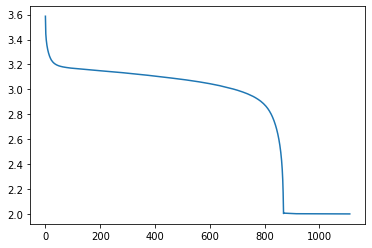

In [10]:
a = structured_data_list[0][0].sort_values('test_time', ascending=True)
plt.plot(a['test_time'], a['voltage'])


(0.8, 1.2)

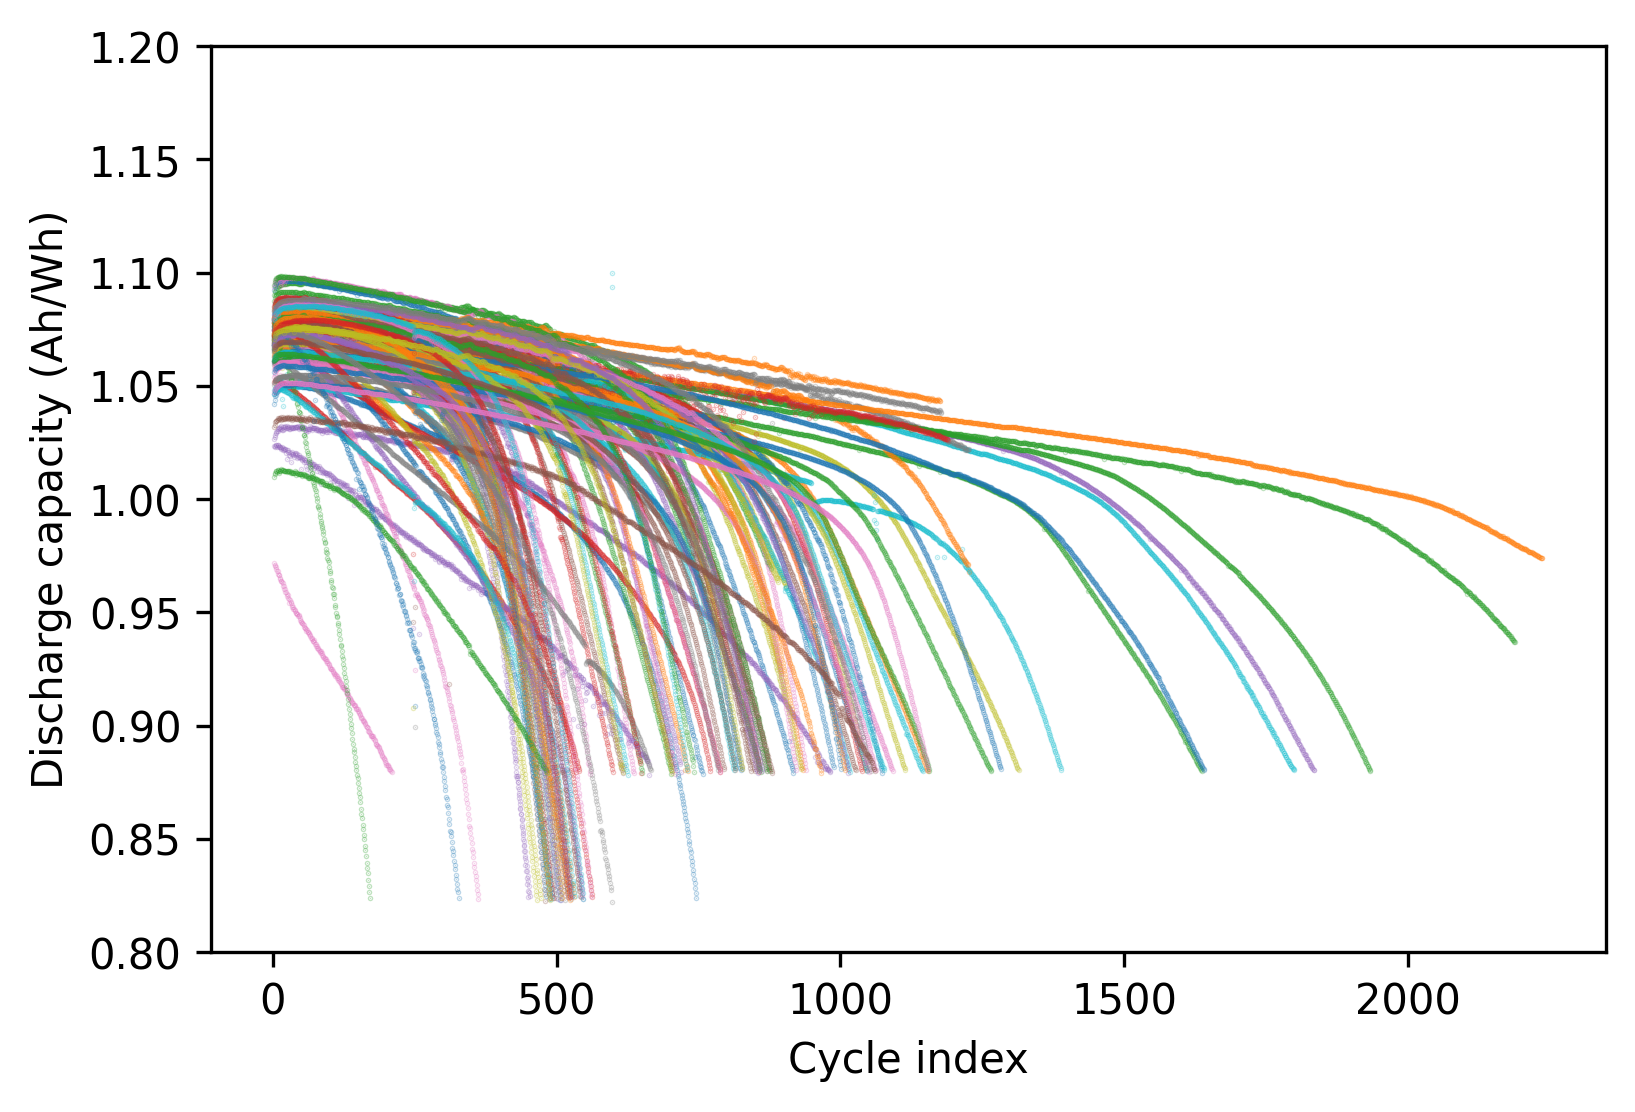

In [11]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycle index')
plt.ylabel('Discharge capacity (Ah/Wh)')
plt.ylim([0.8, 1.2])
# plt.savefig(f'media/LFP/LFP_dataset.png', dpi=400, transparent=False)

In [12]:
def index_convoluter(cell, input_window_size=20, output_window_size=20, overlap_cycle_window=False,
                     overlap_size=5, skip_diagnostic_in_window=False):
    '''This function generates a nested list of indices by convolting the cycles based on cycle_window_size. 
        You can choose to have your window of cycles overlap, or skipp the windows that involve diagnostic cycles in between.
    '''
    max_cycle_index = len(cell) #30 #
    print(max_cycle_index)
    if input_window_size < overlap_size:
        raise ValueError(f'If overlapping, overlap_size ({overlap_size}) should be samller than cycle_window_size ({input_window_size}). Please check inputs.')
    if not input_window_size < max_cycle_index:
        raise ValueError(f'cycle_window_size ({input_window_size}) should be samller than maximum number of cycles in cell ({max_cycle_index}). Please check inputs.')
    if overlap_cycle_window:
        non_overlap =  input_window_size - overlap_size
    else:
        non_overlap = input_window_size
    intervals = range(0, max_cycle_index, non_overlap)
    if not skip_diagnostic_in_window:
        input_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size]
    else:
#         skipped_indices = [5, 6, 7, 20]
        skipped_indices = find_renumbedred_index(cell)
        input_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size
                             and not (set(list(range(x, x + cycle_window_size))[:-1]) & set(skipped_indices))]
    output_covolutions = [list(range(x[-1]+1, x[-1] + output_window_size +1)) for x in input_covolutions if x[-1] < max_cycle_index- output_window_size]
        
    return input_covolutions[:len(output_covolutions)], output_covolutions

In [13]:
skip_diagnostic_in_window=False

input_covolutions, output_covolutions  = index_convoluter(structured_data_list[0], overlap_cycle_window=False, 
                                     overlap_size=10, input_window_size=input_window_size,
                                                          output_window_size=output_window_size,
                                               skip_diagnostic_in_window=skip_diagnostic_in_window)

917


In [14]:
# input_covolutions, output_covolutions  = index_convoluter(cell, overlap_cycle_window=False, 
#                                              overlap_size=10, input_window_size=50, output_window_size=100,
#                                                        skip_diagnostic_in_window=skip_diagnostic_in_window)
# # print(output_covolutions)

In [15]:
def find_slope(cycle_window_label):
    mid_window_index = len(cycle_window_label)//2
    low = np.array(cycle_window_label)[0]
    mid = np.array(cycle_window_label)[mid_window_index]
    high = np.array(cycle_window_label)[-1]
#     print(low[0], mid[0], high[0])
    slope_1 = (mid[1] - low[1]) / (mid[0] - low[0]) # mid_window_index #
    slope_2 = (high[1] - mid[1]) / (mid[0] - low[0]) # mid_window_index
    return slope_1, slope_2

import pickle as pkl
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP_new_structured_by_Amalie/features_labels_inputs_window_{input_window_size}_outputs_window_{output_window_size}.pkl'

test_conv = True
if not os.path.exists(pkl_f_l_filename) or test_conv:

    skip_diagnostic_in_window = False

    features_columns = ['cycle_index', 'test_time','voltage', 'current']
    label_columns = ['cycle_index', 'discharge_capacity']
    # features = np.empty([0, None,100, 3])
    monitored_cycles_discharge_capacity = []
    labels = np.empty([0, 2])
    cell_features = []
    cell_labels = []
    cell_discharge_caps = []
    initial_discharge_cap_windows = []
    for i, cell in enumerate(tqdm(structured_data_list)):
    #     print(i)
    #     n = len(cell)//cycle_numbers
        if len(cell) > 0:
            cycle_window_features = []
            cycle_window_labels = []
            initial_discharge_cap = []
            cell_cycle_indices = summary_data_list[i]['cycle_index'].values
            input_covolutions, output_covolutions  = index_convoluter(cell, overlap_cycle_window=False, 
                                                 overlap_size=10, input_window_size=input_window_size,
                                                                      output_window_size=output_window_size,
                                                           skip_diagnostic_in_window=skip_diagnostic_in_window)
        #     print(len(index_convolution))
    #         for j, index_list in enumerate(index_convolution):
            for j, (input_index_list, output_index_list) in enumerate(zip(input_covolutions, output_covolutions)):
        #         if (j < len(index_convolution)-1):
                    cycle_window_features.append(list(zip(*[(bye_cycle.interpol_cycle(cell[cycle_index], columns=features_columns, n_points=100, interpol_kind='cubic')
                                                             , max(cell[cycle_index]['test_time'])- min(cell[cycle_index]['test_time']) )
                                         for cycle_index in input_index_list])))
            #         break
            #         print (index_list)
            #         print(summary_data_list[i][label_columns])
            #         discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[index_list]
        #             print(index_convolution[j])
                    discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[output_index_list]
    #                 print(j, discharge_cap_cycle_window )

                    cycle_window_labels.append(list([find_slope(discharge_cap_cycle_window), discharge_cap_cycle_window]))
        #         if j == 0:
        #             initial_discharge_cap.append(np.array(summary_data_list[i][label_columns])[index_convolution[j]])
            #         cycle_window_labels.append(discharge_cap_cycle_window)
            #     break
            cell_features.append(cycle_window_features)
            cell_labels.append(cycle_window_labels)
#         break
    #     initial_discharge_cap_windows.append(initial_discharge_cap)
#     with open(pkl_f_l_filename, 'wb') as f:
#         pkl.dump([cell_features, cell_labels], f)
else:
    print('Loaded CACHED pickled files for features and labels.')
    with open(pkl_f_l_filename, 'rb') as f:
        [cell_features, cell_labels] = pkl.load(f)  

  0%|          | 0/139 [00:00<?, ?it/s]

917


  1%|          | 1/139 [00:02<06:04,  2.64s/it]

521


  1%|▏         | 2/139 [00:04<04:21,  1.91s/it]

1638


  2%|▏         | 3/139 [00:08<07:18,  3.23s/it]

520


  3%|▎         | 4/139 [00:10<05:38,  2.50s/it]

982


  4%|▎         | 5/139 [00:13<05:49,  2.61s/it]

616


  4%|▍         | 6/139 [00:14<05:05,  2.30s/it]

636


  5%|▌         | 7/139 [00:16<04:37,  2.11s/it]

496


  6%|▌         | 8/139 [00:17<03:59,  1.83s/it]

905


  6%|▋         | 9/139 [00:20<04:30,  2.08s/it]

1801


  7%|▋         | 10/139 [00:27<07:38,  3.56s/it]

746


  8%|▊         | 11/139 [00:29<06:34,  3.09s/it]

896


  9%|▊         | 12/139 [00:31<06:08,  2.90s/it]

878


  9%|▉         | 13/139 [00:34<05:50,  2.78s/it]

858


 10%|█         | 14/139 [00:36<05:40,  2.72s/it]

450


 11%|█         | 15/139 [00:38<04:43,  2.29s/it]

876


 12%|█▏        | 16/139 [00:40<04:52,  2.38s/it]

940


 12%|█▏        | 17/139 [00:43<05:02,  2.48s/it]

521


 13%|█▎        | 18/139 [00:44<04:22,  2.17s/it]

901


 14%|█▎        | 19/139 [00:47<04:41,  2.34s/it]

1146


 14%|█▍        | 20/139 [00:50<05:16,  2.66s/it]

757


 15%|█▌        | 21/139 [00:53<04:59,  2.54s/it]

531


 16%|█▌        | 22/139 [00:54<04:18,  2.21s/it]

651


 17%|█▋        | 23/139 [00:56<04:06,  2.13s/it]

857


 17%|█▋        | 24/139 [00:59<04:20,  2.26s/it]

453


 18%|█▊        | 25/139 [01:00<03:44,  1.97s/it]

480


 19%|█▊        | 26/139 [01:01<03:19,  1.77s/it]

1093


 19%|█▉        | 27/139 [01:04<04:06,  2.20s/it]

1226


 20%|██        | 28/139 [01:08<04:54,  2.65s/it]

1046


 21%|██        | 29/139 [01:11<05:04,  2.77s/it]

488


 22%|██▏       | 30/139 [01:12<04:13,  2.33s/it]

1048


 22%|██▏       | 31/139 [01:16<04:34,  2.54s/it]

935


 23%|██▎       | 32/139 [01:20<05:31,  3.10s/it]

860


 24%|██▎       | 33/139 [01:23<05:12,  2.94s/it]

541


 24%|██▍       | 34/139 [01:24<04:21,  2.49s/it]

663


 25%|██▌       | 35/139 [01:26<04:01,  2.32s/it]

1028


 26%|██▌       | 36/139 [01:29<04:21,  2.54s/it]

870


 27%|██▋       | 37/139 [01:32<04:20,  2.55s/it]

526


 27%|██▋       | 38/139 [01:33<03:44,  2.22s/it]

1315


 28%|██▊       | 39/139 [01:37<04:36,  2.76s/it]

813


 29%|██▉       | 40/139 [01:39<04:23,  2.66s/it]

492


 29%|██▉       | 41/139 [01:41<03:40,  2.25s/it]

1155


 30%|███       | 42/139 [01:44<04:15,  2.64s/it]

702


 31%|███       | 43/139 [01:46<03:57,  2.47s/it]

772


 32%|███▏      | 44/139 [01:49<03:48,  2.41s/it]

1836


 32%|███▏      | 45/139 [01:54<05:16,  3.37s/it]

541


 33%|███▎      | 46/139 [01:56<04:19,  2.79s/it]

362


 34%|███▍      | 47/139 [01:57<03:26,  2.25s/it]

827


 35%|███▍      | 48/139 [01:59<03:29,  2.30s/it]

932


 35%|███▌      | 49/139 [02:02<03:40,  2.45s/it]

1390


 36%|███▌      | 50/139 [02:06<04:24,  2.97s/it]

506


 37%|███▋      | 51/139 [02:07<03:41,  2.51s/it]

1226


 37%|███▋      | 52/139 [02:11<04:09,  2.87s/it]

1039


 39%|███▉      | 54/139 [02:14<03:10,  2.25s/it]

719


 40%|███▉      | 55/139 [02:16<03:05,  2.21s/it]

850


 40%|████      | 56/139 [02:19<03:11,  2.30s/it]

709


 41%|████      | 57/139 [02:21<03:04,  2.25s/it]

515


 42%|████▏     | 58/139 [02:22<02:43,  2.02s/it]

465


 42%|████▏     | 59/139 [02:24<02:24,  1.81s/it]

1017


 43%|████▎     | 60/139 [02:27<02:51,  2.17s/it]

1284


 44%|████▍     | 61/139 [02:32<04:11,  3.22s/it]

524


 45%|████▍     | 62/139 [02:34<03:27,  2.70s/it]

1935


 45%|████▌     | 63/139 [02:40<04:38,  3.66s/it]

599


 46%|████▌     | 64/139 [02:41<03:48,  3.05s/it]

854


 47%|████▋     | 65/139 [02:44<03:34,  2.91s/it]

796


 47%|████▋     | 66/139 [02:46<03:17,  2.71s/it]

209


 48%|████▊     | 67/139 [02:47<02:27,  2.04s/it]

499


 49%|████▉     | 68/139 [02:48<02:08,  1.82s/it]

1115


 50%|████▉     | 69/139 [02:51<02:39,  2.28s/it]

817


 50%|█████     | 70/139 [02:54<02:39,  2.32s/it]

989


 51%|█████     | 71/139 [02:57<02:49,  2.49s/it]

1176


 52%|█████▏    | 72/139 [03:00<03:07,  2.80s/it]

171


 53%|█████▎    | 73/139 [03:01<02:15,  2.06s/it]

493


 53%|█████▎    | 74/139 [03:02<01:58,  1.82s/it]

546


 54%|█████▍    | 75/139 [03:03<01:49,  1.71s/it]

527


 55%|█████▍    | 76/139 [03:05<01:42,  1.63s/it]

559


 55%|█████▌    | 77/139 [03:06<01:40,  1.62s/it]

666


 56%|█████▌    | 78/139 [03:08<01:44,  1.71s/it]

472


 57%|█████▋    | 79/139 [03:10<01:34,  1.58s/it]

532


 58%|█████▊    | 80/139 [03:11<01:30,  1.54s/it]

825


 58%|█████▊    | 81/139 [03:13<01:44,  1.80s/it]

2237


 59%|█████▉    | 82/139 [03:20<03:09,  3.32s/it]

870


 60%|█████▉    | 83/139 [03:23<02:53,  3.09s/it]

648


 60%|██████    | 84/139 [03:25<02:28,  2.69s/it]

503


 61%|██████    | 85/139 [03:26<02:05,  2.32s/it]

542


 62%|██████▏   | 86/139 [03:27<01:48,  2.06s/it]

1063


 63%|██████▎   | 87/139 [03:31<02:04,  2.40s/it]

487


 63%|██████▎   | 88/139 [03:32<01:45,  2.06s/it]

828


 64%|██████▍   | 89/139 [03:34<01:48,  2.16s/it]

625


 65%|██████▍   | 90/139 [03:36<01:40,  2.04s/it]

1074


 65%|██████▌   | 91/139 [03:39<01:54,  2.39s/it]

731


 66%|██████▌   | 92/139 [03:41<01:48,  2.30s/it]

1267


 67%|██████▋   | 93/139 [03:45<02:06,  2.76s/it]

1189


 68%|██████▊   | 94/139 [03:49<02:14,  2.98s/it]

1014


 68%|██████▊   | 95/139 [03:52<02:11,  3.00s/it]

704


 69%|██████▉   | 96/139 [03:54<01:57,  2.72s/it]

923


 70%|██████▉   | 97/139 [03:59<02:21,  3.37s/it]

1178


 71%|███████   | 98/139 [04:02<02:20,  3.41s/it]

508


 71%|███████   | 99/139 [04:04<01:52,  2.82s/it]

731


 72%|███████▏  | 100/139 [04:06<01:41,  2.60s/it]

1642


 73%|███████▎  | 101/139 [04:11<02:05,  3.30s/it]

966


 73%|███████▎  | 102/139 [04:14<01:57,  3.17s/it]

876


 74%|███████▍  | 103/139 [04:16<01:47,  2.99s/it]

788


 75%|███████▍  | 104/139 [04:18<01:36,  2.76s/it]

545


 76%|███████▌  | 105/139 [04:20<01:20,  2.37s/it]

880


 76%|███████▋  | 106/139 [04:22<01:19,  2.42s/it]

1051


 77%|███████▋  | 107/139 [04:26<01:24,  2.65s/it]

858


 78%|███████▊  | 108/139 [04:28<01:21,  2.62s/it]

890


 78%|███████▊  | 109/139 [04:31<01:18,  2.60s/it]

490


 79%|███████▉  | 110/139 [04:32<01:03,  2.21s/it]

481


 80%|███████▉  | 111/139 [04:33<00:54,  1.93s/it]

1009


 81%|████████  | 112/139 [04:36<01:01,  2.26s/it]

483


 81%|████████▏ | 113/139 [04:38<00:51,  1.97s/it]

563


 82%|████████▏ | 114/139 [04:39<00:46,  1.86s/it]

862


 83%|████████▎ | 115/139 [04:42<00:49,  2.07s/it]

842


 83%|████████▎ | 116/139 [04:44<00:49,  2.17s/it]

788


 84%|████████▍ | 117/139 [04:46<00:48,  2.19s/it]

1054


 85%|████████▍ | 118/139 [04:50<00:52,  2.49s/it]

488


 86%|████████▌ | 119/139 [04:51<00:42,  2.13s/it]

1078


 86%|████████▋ | 120/139 [04:54<00:46,  2.44s/it]

1002


 87%|████████▋ | 121/139 [04:57<00:47,  2.62s/it]

510


 88%|████████▊ | 122/139 [04:59<00:38,  2.27s/it]

742


 88%|████████▊ | 123/139 [05:01<00:35,  2.23s/it]

534


 89%|████████▉ | 124/139 [05:02<00:29,  1.99s/it]

508


 90%|████████▉ | 125/139 [05:04<00:25,  1.83s/it]

1061


 91%|█████████ | 126/139 [05:07<00:29,  2.24s/it]

561


 91%|█████████▏| 127/139 [05:08<00:24,  2.05s/it]

786


 92%|█████████▏| 128/139 [05:11<00:23,  2.10s/it]

617


 93%|█████████▎| 129/139 [05:12<00:19,  2.00s/it]

547


 94%|█████████▎| 130/139 [05:14<00:16,  1.83s/it]

327


 94%|█████████▍| 131/139 [05:15<00:12,  1.52s/it]

488


 95%|█████████▍| 132/139 [05:16<00:10,  1.45s/it]

1158


 96%|█████████▌| 133/139 [05:19<00:12,  2.07s/it]

523


 96%|█████████▋| 134/139 [05:21<00:09,  1.88s/it]

525


 97%|█████████▋| 135/139 [05:22<00:06,  1.75s/it]

816


 98%|█████████▊| 136/139 [05:25<00:05,  1.94s/it]

1156


 99%|█████████▊| 137/139 [05:28<00:04,  2.41s/it]

597


 99%|█████████▉| 138/139 [05:30<00:02,  2.17s/it]

703


100%|██████████| 139/139 [05:32<00:00,  2.39s/it]


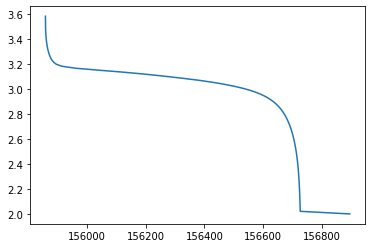

In [16]:
# Checking interpolation
c = cycle_window_features[1][0][0]
plt.plot(c[:,1], c[:,2])

In [17]:
# cell = structured_data_list[0]

# def index_convoluter(cell, input_window_size=20, output_window_size=20, overlap_cycle_window=False, 
#                      overlap_size=5, skip_diagnostic_in_window=False):
#     '''This function generates a nested list of indices by convolting the cycles based on cycle_window_size. 
#         You can choose to have your window of cycles overlap, or skipp the windows that involve diagnostic cycles in between.
#     '''
# #     input_window_size = 20
#     output_window_size = 40
#     max_cycle_index = len(cell) #30 #
#     print(max_cycle_index)
#     if cycle_window_size < overlap_size:
#         raise ValueError(f'If overlapping, overlap_size ({overlap_size}) should be samller than cycle_window_size ({input_window_size}). Please check inputs.')
#     if not cycle_window_size < max_cycle_index:
#         raise ValueError(f'cycle_window_size ({input_window_size}) should be samller than maximum number of cycles in cell ({max_cycle_index}). Please check inputs.')
#     if overlap_cycle_window:
#         non_overlap =  input_window_size - overlap_size
#     else:
#         non_overlap = input_window_size
#     intervals = range(0, max_cycle_index, non_overlap)
#     if not skip_diagnostic_in_window:
#         index_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size]
#     else:
# #         skipped_indices = [5, 6, 7, 20]
#         skipped_indices = find_renumbedred_index(cell)
#         index_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size
#                              and not (set(list(range(x, x + cycle_window_size))[:-1]) & set(skipped_indices))]
#     output_covolutions = [list(range(x[-1]+1, x[-1] + output_window_size +1)) for x in index_covolutions if x[-1] < max_cycle_index- output_window_size]
        
#     return index_covolutions[:len(output_covolutions)], output_covolutions

# input_window_size = 20
# output_window_size = 50
# index_convolution, output_covolution = index_convoluter(cell, overlap_cycle_window=False, 
#                                      overlap_size=10, input_window_size=input_window_size,
#                                                skip_diagnostic_in_window=False)
# # print(index_convolution)

In [18]:
# # print(index_convolution[-1])
# for m,n in zip(index_convolution, output_covolution):
#     print(m,n)

In [19]:
import random
prepared_data = list(zip(cell_features, cell_labels))

random.seed(0)
shuffled_indices = list(range(len(prepared_data)))
random.shuffle(prepared_data)
# prepared_data = prepared_data[shuffled_indices]

train_size = 0.9
val_size = 0.2
N_train = int(train_size *len(prepared_data))
N_val = int(val_size * N_train)
train_cells = prepared_data[:N_train]
test_cells = prepared_data[N_train:]

val_cells = train_cells[:N_val]
train_cells = train_cells[N_val:]
print(len(train_cells), len(val_cells), len(test_cells), len(train_cells)+len(test_cells)+len(val_cells))

100 24 14 138


In [20]:
def scale(inputs, scaler=None):
    from sklearn import preprocessing
    inputs_shape = inputs.shape
    if scaler is None:
        scaler = preprocessing.StandardScaler().fit(inputs.reshape(-1, inputs_shape[-1]))
    scaled_input = scaler.transform(inputs.reshape(-1, inputs_shape[-1])).reshape(inputs_shape)
    return scaler, scaled_input

def rev_scale(scaled_inputs, scaler):
    scaled_inputs_shape = scaled_inputs.shape
    origin_inputs = scaler.inverse_transform(scaled_X_train_time_series.reshape(-1, scaled_inputs_shape[-1]))
    return origin_inputs.reshape(scaled_inputs_shape)



def standardize_train(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features, fmean, fstd

def standardize_non_train(inputs, fmean_train, fstd_train):
    std_features = (inputs - fmean_train) / fstd_train
    return std_features

def de_standardize_non_train(inputs, fmean_train, fstd_train):
    return inputs*fstd_train + fmean_train

def make_feature_arrays(data):
    X_dt_values = []
    X_time_series = []
    for X in data:
        X_dt_values.append(X[1])
        X_time_series.append(X[0])
#         break
    return np.array(X_time_series), np.array(X_dt_values)

def make_label_arrays(data):
    slopes = []
    discharge_cap = []
    for Y in data:
        discharge_cap.append(Y[1])
        slopes.append(Y[0])
    return np.array(discharge_cap), np.array(slopes)

X_train = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
Y_train = [x for xs in train_cells for x in xs[1]]
dc_train, slopes_train = make_label_arrays(Y_train)
X_train_time_series, X_train_dt = make_feature_arrays(X_train)
# print(X_train_time_series[-1][-1])
print(dc_train[-1][0])
print(X_train_time_series[0])
import random
random.seed(0)
indices = list(range(len(X_train_time_series)))
random.shuffle(indices)
print(f'len features {len(X_train_time_series)}')
X_train_time_series = X_train_time_series[indices]
X_train_dt = X_train_dt[indices]
dc_train = dc_train[indices]
slopes_train = slopes_train[indices]


# standardized_train_slopes, mean_train_slopes, std_train_slopes= standardize_train(slopes_train)

print(X_train_time_series[0,0,0,0])
print(dc_train[0][0])

X_val = [x for xs in val_cells for x in xs[0]]
# Y_val= np.array([x for xs in val_cells for x in xs[1]])
Y_val = [x for xs in val_cells for x in xs[1]]
dc_val, slopes_val = make_label_arrays(Y_val)
# standardized_val_slopes= standardize_non_train(slopes_val, mean_train_slopes, std_train_slopes)
X_val_time_series, X_val_dt = make_feature_arrays(X_val)

X_test = [x for xs in test_cells for x in xs[0]]
# Y_test= np.array([x for xs in test_cells for x in xs[1]])
Y_test = [x for xs in test_cells for x in xs[1]]
dc_test, slopes_test = make_label_arrays(Y_test)
# standardized_test_slopes= standardize_non_train(slopes_test, mean_train_slopes, std_train_slopes)
X_test_time_series, X_test_dt = make_feature_arrays(X_test)

f_scaler, scaled_X_train_time_series = scale(X_train_time_series[...,1:])
_ , scaled_X_val_time_series = scale(X_val_time_series[...,1:], f_scaler)
_ , scaled_X_test_time_series = scale(X_test_time_series[...,1:], f_scaler)


dt_scaler, scaled_X_train_dt = scale(X_train_dt)
_ , scaled_X_val_dt = scale(X_val_dt, dt_scaler)
_ , scaled_X_test_dt = scale(X_test_dt, dt_scaler)

l_scaler, scaled_slopes_train = scale(slopes_train)
_ , scaled_slopes_val = scale(slopes_val, l_scaler)
_ , scaled_slopes_test = scale(slopes_test, l_scaler)

[501.      0.937]
[[[ 0.000e+00  0.000e+00  3.587e+00 -5.641e-01]
  [ 0.000e+00  1.039e-01  3.571e+00 -1.273e+00]
  [ 0.000e+00  1.995e-01  3.555e+00 -1.931e+00]
  ...
  [ 0.000e+00  8.563e+02  2.024e+00 -4.400e+00]
  [ 0.000e+00  8.564e+02  2.010e+00 -4.400e+00]
  [ 0.000e+00  1.006e+03  2.000e+00 -1.288e-01]]

 [[ 1.000e+00  3.602e+03  3.587e+00 -5.630e-01]
  [ 1.000e+00  3.602e+03  3.571e+00 -1.271e+00]
  [ 1.000e+00  3.602e+03  3.555e+00 -1.918e+00]
  ...
  [ 1.000e+00  4.460e+03  2.032e+00 -4.400e+00]
  [ 1.000e+00  4.461e+03  2.011e+00 -4.400e+00]
  [ 1.000e+00  4.688e+03  2.000e+00 -7.158e-02]]

 [[ 2.000e+00  7.203e+03  3.586e+00 -6.553e-01]
  [ 2.000e+00  7.203e+03  3.570e+00 -1.361e+00]
  [ 2.000e+00  7.203e+03  3.554e+00 -2.011e+00]
  ...
  [ 2.000e+00  8.063e+03  2.035e+00 -4.400e+00]
  [ 2.000e+00  8.064e+03  2.006e+00 -4.401e+00]
  [ 2.000e+00  8.289e+03  2.000e+00 -7.579e-02]]

 ...

 [[ 4.700e+01  1.693e+05  3.587e+00 -5.863e-01]
  [ 4.700e+01  1.693e+05  3.571e+00 -1.3

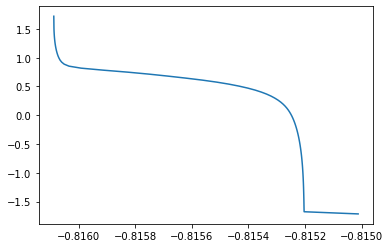

In [21]:
plt.plot(scaled_X_train_time_series[0,0,:,0], scaled_X_train_time_series[0,0,:,1])

In [22]:
X_train_time_series[0][0][:5]

array([[ 0.   ,  0.   ,  3.587, -0.563],
       [ 0.   ,  0.104,  3.571, -1.284],
       [ 0.   ,  0.198,  3.555, -1.945],
       [ 0.   ,  0.291,  3.539, -2.571],
       [ 0.   ,  0.378,  3.523, -3.165]])

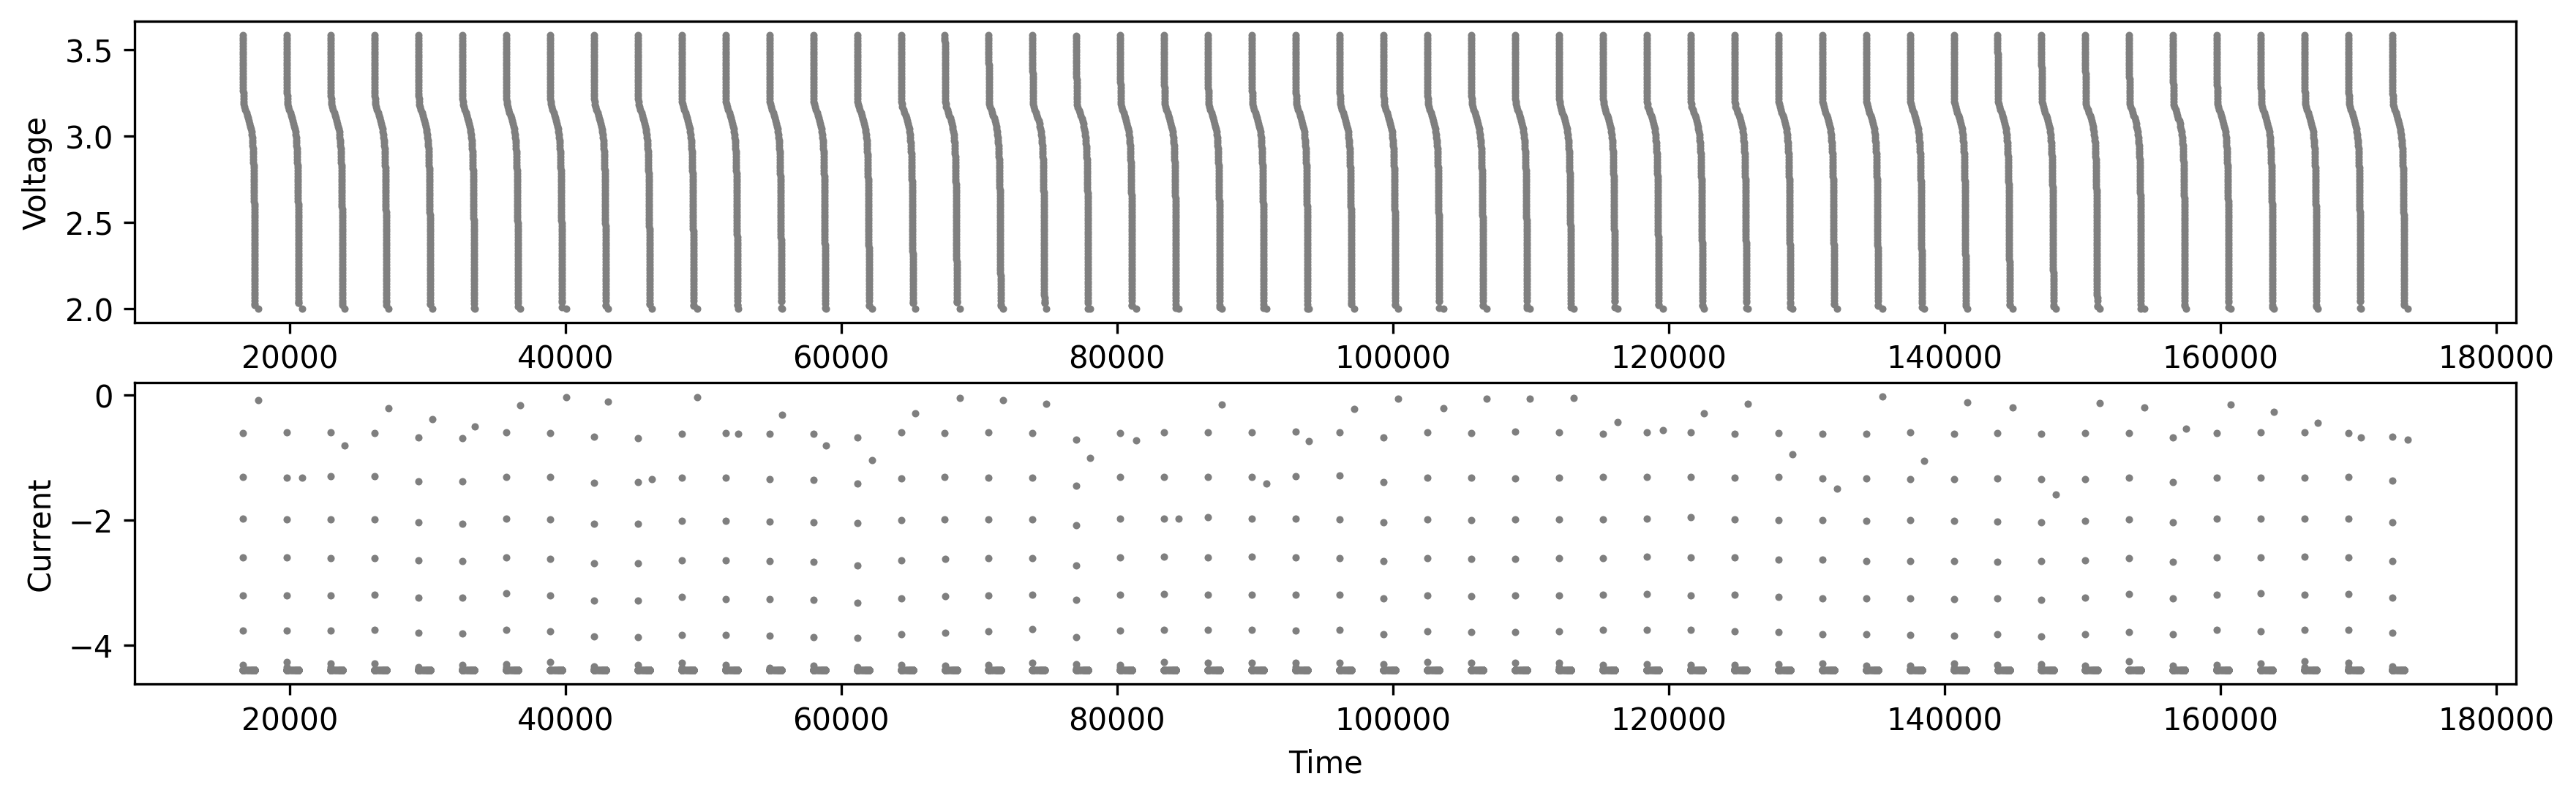

In [24]:
time_series_dat_1 = X_train_time_series[10][...,1:].reshape(-1,3)
fig , ax = plt.subplots(2,1, figsize=(14,4), dpi=300, facecolor='white')
ax[0].scatter(time_series_dat_1[:,0], time_series_dat_1[:,1], color='C7', s=2, marker='o')
ax[0].set_ylabel('Voltage')
ax[1].scatter(time_series_dat_1[:,0] ,time_series_dat_1[:,2], color='C7', s=2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Current')
xmin, xmax = plt.xlim()
plt.savefig(f'media/generative.png', dpi=400, transparent=False, bbox_inches="tight")

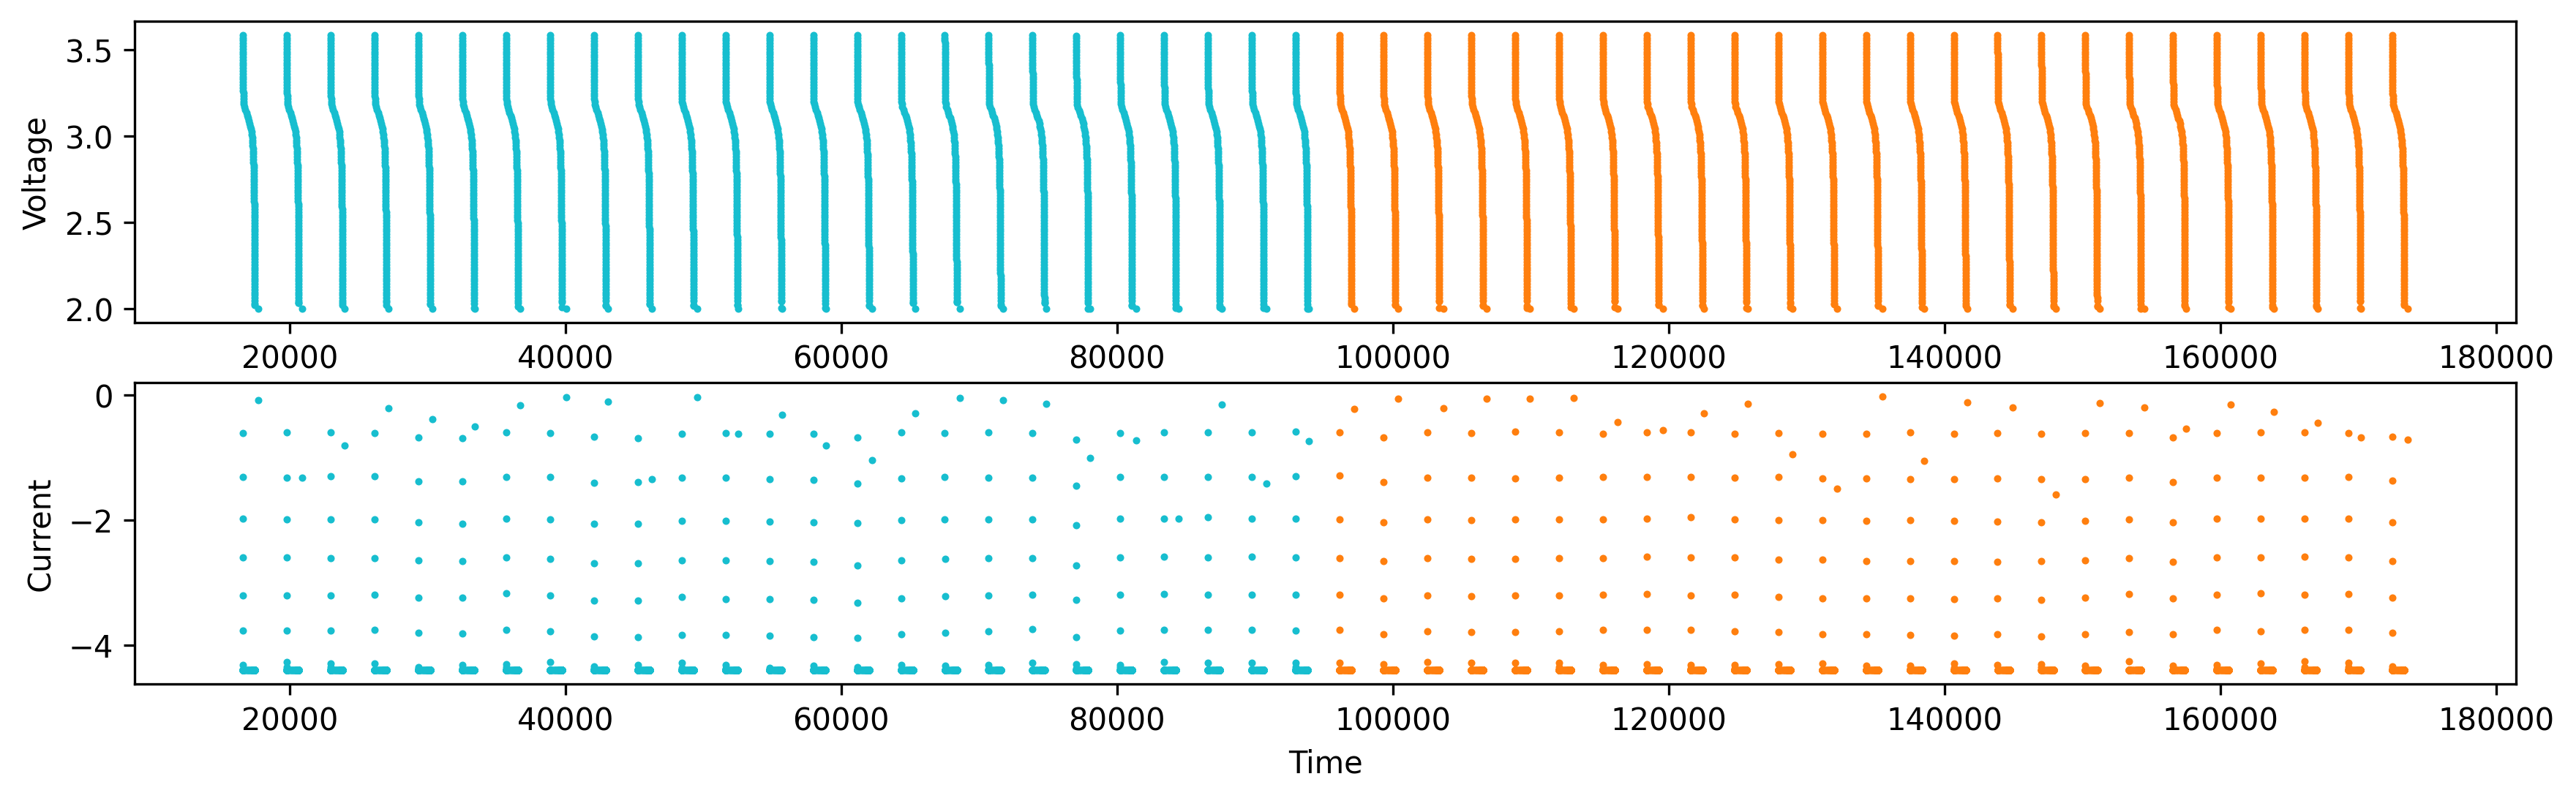

In [37]:
fig , ax = plt.subplots(2,1, figsize=(14,4), dpi=300, facecolor='white')
features_index = time_series_dat_1.shape[0]//2
ax[0].scatter(time_series_dat_1[:features_index,0],time_series_dat_1[:features_index,1], label='Features', color='C9', s=2)
ax[0].scatter(time_series_dat_1[features_index:,0],time_series_dat_1[features_index:,1], label='Labels', color='C1', s=2)
ax[0].set_ylabel('Voltage')
ax[0].set_xlim([xmin, xmax])
ax[1].scatter(time_series_dat_1[:features_index,0], time_series_dat_1[:features_index,2], label='Features', color='C9', s=2)
ax[1].scatter(time_series_dat_1[features_index:,0], time_series_dat_1[features_index:,2], label='Labels', color='C1', s=2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Current')
ax[1].set_xlim([xmin, xmax])
# plt.legend(markerscale=5, bbox_to_anchor=[1.12,2])
plt.savefig(f'media/generative_f_l.png', dpi=400, transparent=False, bbox_inches="tight")

In [31]:
time_series_dat_1

array([[ 1.663e+04,  3.587e+00, -6.050e-01],
       [ 1.663e+04,  3.571e+00, -1.311e+00],
       [ 1.663e+04,  3.555e+00, -1.982e+00],
       ...,
       [ 1.733e+05,  2.032e+00, -4.400e+00],
       [ 1.733e+05,  2.024e+00, -4.400e+00],
       [ 1.736e+05,  2.002e+00, -7.174e-01]])

Text(0.5, 1.0, 'slope 1')

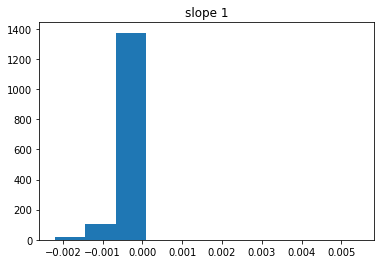

In [60]:
plt.hist(slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 1')

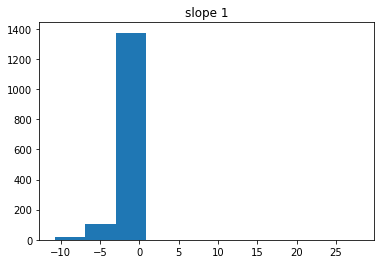

In [61]:
plt.hist(scaled_slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

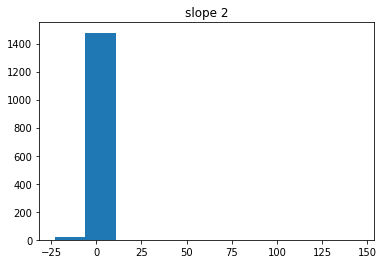

In [62]:
plt.hist(scaled_slopes_train[:,1])
plt.title('slope 2')

In [289]:
def oversample(f_time_series, f_dt, labels, oversample_label_index=1):
    counts, bins, patches = plt.hist(labels[:,oversample_label_index], bins=20)
    plt.close()
    import numpy_indexed as npi
    import random
    max_samples = max(counts)
    ind = np.digitize(labels[:,oversample_label_index], bins)
    label_groups = npi.group_by(ind).split(labels[:,oversample_label_index])

    balanced_f_time_series = f_time_series
    balanced_labels = labels
    balanced_f_dt = f_dt
    for sg in tqdm(label_groups[:-2]):
        n_samples = int(max_samples - len(sg))
        # Find indices for samples
        sample_indices = npi.indices(labels[:, oversample_label_index], np.random.choice(sg, n_samples))
        balanced_f_time_series = np.append(balanced_f_time_series,
                                                     f_time_series[sample_indices], axis=0)
        balanced_labels = np.append(balanced_labels,
                                                     labels[sample_indices], axis=0)
        balanced_f_dt = np.append(balanced_f_dt,
                                                f_dt[sample_indices], axis=0)
    
#     random.seed(0)
    shuffled_indices = list(range(len(balanced_f_time_series)))
    random.shuffle(indices)
    return balanced_f_time_series[shuffled_indices], balanced_f_dt[shuffled_indices], balanced_labels[shuffled_indices]

balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(scaled_X_train_time_series,
                                                                                               X_train_dt,
                                                                                               scaled_slopes_train, oversample_label_index=1)
# balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(balanced_X_train_time_series,
#                                                                                                balanced_X_train_dt,
#                                                                                                balanced_slopes_train, oversample_label_index=1)

100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Text(0.5, 1.0, 'slope 1')

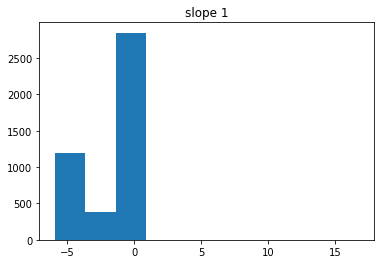

In [290]:
plt.hist(balanced_slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

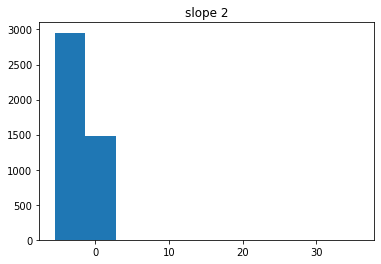

In [291]:
plt.hist(balanced_slopes_train[:,1])
plt.title('slope 2')

Text(0.5, 1.0, 'slope 2')

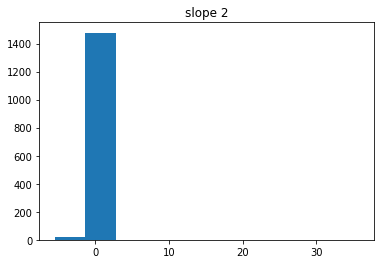

In [292]:
plt.hist(scaled_slopes_train[:,1])
plt.title('slope 2')

In [293]:
# scaled_X_train_dt, mean_X_train_dt, std_X_train_dt  = standardize_train(X_train_dt)
# scaled_X_val_dt = standardize_non_train(X_val_dt, mean_X_train_dt, std_X_train_dt)

# scaled_X_train_time_series, mean_X_train_time_series, std_X_train_time_series = standardize_train(X_train_time_series)
# scaled_X_val_time_series = standardize_non_train(X_val_time_series, mean_X_train_time_series, std_X_train_time_series)
# X_train_time_series = X_train_time_series
# print
# scaled_X_train_time_series = scaled_X_train_time_series[...,1:]
# scaled_X_val_time_series = scaled_X_val_time_series[...,1:]


# test_X_train_time_series = rev_scale(scaled_X_train_time_series[...,1:], scaler)


In [294]:
# # best model
# from dataclasses import dataclass
# @dataclass
# class Config:
#     batch_size: int
#     buffer_size: int
#     rnn_units: int
#     hidden_dim: int
#     embedding_dim: int
#     reg_strength: float
#     lr: float
#     drop_rate: float
        
# config = Config(batch_size=16, 
#                 buffer_size=10000,
#                 rnn_units=64,
#                 hidden_dim=64,
#                 embedding_dim=32,
#                 reg_strength=0,
#                 lr=1e-3,
#                 drop_rate=0.1
#                )

# def build_model(L, T, cycle_window_size=10, reg_strength=0, n_features=3):
#     inputs = tf.keras.Input(shape=(cycle_window_size, T , n_features))
#     input_dt = tf.keras.Input(shape=(cycle_window_size))
#     print(f'input: {inputs.shape}')
#     print(f'input_dt: {input_dt.shape}')
# #     x=inputs.Reshape(100, cycle_window_size, 3)
# #     x =  tf.keras.layers.Reshape((cycle_window_size* T , 2))(inputs)
# #     conv_1d_layer = tf.keras.layers.Conv1D(32, 50, activation='relu')
# #     max_pooling = 
# #     blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
# #     x = tf.keras.layers.Embedding(100,16)(inputs)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 100), input_shape=(cycle_window_size, T , n_features))(inputs)
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)

#     print(f'output 1 conv: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
# #     print(f'output max_pooling 1: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 10 ,2))(x)
# #     print(f'output 2 conv: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
# #     print(f'output max_pooling 2: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 2))(x)
# #     print(f'output 3 conv: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
# #     print(f'output max_pooling 3: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 10), input_shape=(cycle_window_size, 2))(x)
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(100, 2))(x)
# #     print(f'output 3 conv: {x.shape}')
# #     x = tf.keras.layers.TimeDistributed(max_pooling)(x)
# #     print(f'output max_pooling 2: {x.shape}')
# #     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(config.drop_rate))(x)
#     print(f'output dropout: {x.shape}')
# #     x = tf.keras.layers.Reshape((cycle_window_size, 32))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
# #     x = tf.keras.layers.Flatten()(x)
# #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
# #     
#     print(f'output GlobalAveragePooling1D: {x.shape}')
# #     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
# #     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
#     print(x.shape)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False))(x)
#     print(f'output bilstm dist: {x.shape}')
# #     x = tf.keras.layers.Concatenate()([x, input_dt])
# #     x = tf.keras.layers.LayerNormalization()(x)
# #     x = tf.keras.layers.BatchNormalization()(x)
# #     x = tf.keras.layers.Dropout(config.drop_rate)(x)
#     x = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
# #     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.Dropout(config.drop_rate)(x)
#     x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
# #     x = tf.keras.layers.BatchNormalization()(x)
# #     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
# #                                     output_dim=config.embedding_dim,
# #                                     mask_zero=True)(inputs)
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.Dropout(config.drop_rate)(x)
#     yhat = tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength)
#                                  )(x) # activation=tf.keras.layers.LeakyReLU(alpha=0.01)
#     model = tf.keras.Model(inputs=[inputs, input_dt], outputs=yhat)
# #     model = tf.keras.Model(inputs=inputs, outputs=yhat)
#     return model
# tf.keras.backend.clear_session()
# L = None
# T = 100

# from keras import backend as K
# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
# n_features = scaled_X_train_time_series.shape[-1]
# model = build_model(L, T, cycle_window_size=input_window_size, reg_strength=0.001, n_features=n_features)
# opt = tf.optimizers.Adam(1e-3)
# model.compile(opt, loss='mae')  #root_mean_squared_error
# #   loss='mean_absolute_error')
  
# model.summary()


In [324]:
# best model
from dataclasses import dataclass
@dataclass
class Config:
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def build_model(L, T, cycle_window_size=10, reg_strength=0, n_features=3):
    inputs = tf.keras.Input(shape=(cycle_window_size, T , n_features))
    input_dt = tf.keras.Input(shape=(cycle_window_size))
    print(f'input: {inputs.shape}')
    print(f'input_dt: {input_dt.shape}')
#     x=inputs.Reshape(100, cycle_window_size, 3)
#     x =  tf.keras.layers.Reshape((cycle_window_size* T , 2))(inputs)
#     conv_1d_layer = tf.keras.layers.Conv1D(32, 50, activation='relu')
#     max_pooling = 
#     blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
#     x = tf.keras.layers.Embedding(100,16)(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 100), input_shape=(cycle_window_size, T , n_features))(inputs)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)

    #     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, T , 2))(x)

    print(f'output 1 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 1: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 10 ,2))(x)
#     print(f'output 2 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 3: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 10), input_shape=(cycle_window_size, 2))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(100, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(max_pooling)(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(config.drop_rate))(x)
    print(f'output dropout: {x.shape}')
#     x = tf.keras.layers.Reshape((cycle_window_size, 32))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     
    print(f'output GlobalAveragePooling1D: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    print(x.shape)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False))(x)
    x = tf.keras.layers.LSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(16, return_sequences=False)(x)

    print(f'output bilstm dist: {x.shape}')
#     x = tf.keras.layers.Concatenate()([x, input_dt])
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    yhat = tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength),
                                 activation='tanh')(x) # activation=tf.keras.layers.LeakyReLU(alpha=0.01)
    model = tf.keras.Model(inputs=[inputs, input_dt], outputs=yhat)
#     model = tf.keras.Model(inputs=inputs, outputs=yhat)
    return model
tf.keras.backend.clear_session()
L = None
T = 100

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
n_features = scaled_X_train_time_series.shape[-1]
model = build_model(L, T, cycle_window_size=input_window_size, reg_strength=0.001, n_features=n_features)
opt = tf.optimizers.Adam(1e-3)
model.compile(opt, loss='huber')  #root_mean_squared_error
#   loss='mean_absolute_error')
  
model.summary()


input: (None, 50, 100, 3)
input_dt: (None, 50)
output 1 conv: (None, 50, 1, 32)
output dropout: (None, 50, 1, 32)
output GlobalAveragePooling1D: (None, 50, 32)
(None, 50, 32)
output bilstm dist: (None, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 time_distributed (TimeDistribu  (None, 50, 1, 32)   9632        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                      

In [325]:
# result = model.fit(
#     scaled_X_train_time_series, -np.log(-balanced_slopes_train), # standardize
# #     scaled_X_train_time_series, balanced_slopes_train,
#     validation_data=(scaled_X_val_time_series, -np.log(-slopes_val)), 
# #     validation_data=(scaled_X_val_time_series, slopes_val), 
#     callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
#             monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
#         ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# # #         tf.keras.callbacks.LambdaCallback(
# # #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# # #         ),
# #         ,
#     epochs=150, batch_size=16)

result = model.fit( 
#     balanced_X_train_time_series, balanced_slopes_train, # standardize
    (scaled_X_train_time_series, scaled_X_train_dt), scaled_slopes_train, # standardize

#     (scaled_X_train_time_series, scaled_X_train_dt), scaled_slopes_train, # standardize

#     scaled_X_train_time_series, scaled_slopes_train, # standardize
    validation_data=([scaled_X_val_time_series, X_val_dt], scaled_slopes_val), 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), 
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=50)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=1000, batch_size=16)

Epoch 1/1000
94/94 [==============================] - 7s 34ms/step - loss: 0.4357 - val_loss: 0.3653 - lr: 0.0010
Epoch 2/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.4040 - val_loss: 0.3462 - lr: 0.0010
Epoch 3/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.3799 - val_loss: 0.3315 - lr: 0.0010
Epoch 4/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.3574 - val_loss: 0.3115 - lr: 0.0010
Epoch 5/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.3366 - val_loss: 0.3046 - lr: 0.0010
Epoch 6/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.3155 - val_loss: 0.2851 - lr: 0.0010
Epoch 7/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.3007 - val_loss: 0.2767 - lr: 0.0010
Epoch 8/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.2846 - val_loss: 0.2638 - lr: 0.0010
Epoch 9/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.2661 - val_

Epoch 71/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1321 - val_loss: 0.1271 - lr: 7.2900e-04
Epoch 72/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1305 - val_loss: 0.1276 - lr: 7.2900e-04
Epoch 73/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1301 - val_loss: 0.1248 - lr: 6.5610e-04
Epoch 74/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.1275 - val_loss: 0.1271 - lr: 6.5610e-04
Epoch 75/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1357 - val_loss: 0.1360 - lr: 6.5610e-04
Epoch 76/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1301 - val_loss: 0.1262 - lr: 6.5610e-04
Epoch 77/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1336 - val_loss: 0.1283 - lr: 6.5610e-04
Epoch 78/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.1293 - val_loss: 0.1292 - lr: 5.9049e-04
Epoch 79/1000
94/94 [===========================

94/94 [==============================] - 2s 23ms/step - loss: 0.1216 - val_loss: 0.1234 - lr: 2.2877e-04
Epoch 140/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1207 - val_loss: 0.1196 - lr: 2.0589e-04
Epoch 141/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1209 - val_loss: 0.1246 - lr: 2.0589e-04
Epoch 142/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.1196 - val_loss: 0.1227 - lr: 2.0589e-04
Epoch 143/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1205 - val_loss: 0.1185 - lr: 2.0589e-04
Epoch 144/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1206 - val_loss: 0.1198 - lr: 2.0589e-04
Epoch 145/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1208 - val_loss: 0.1188 - lr: 1.8530e-04
Epoch 146/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1212 - val_loss: 0.1193 - lr: 1.8530e-04
Epoch 147/1000
94/94 [==============================] -

94/94 [==============================] - 2s 23ms/step - loss: 0.1179 - val_loss: 0.1211 - lr: 5.8150e-05
Epoch 208/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1170 - val_loss: 0.1187 - lr: 5.8150e-05
Epoch 209/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1169 - val_loss: 0.1206 - lr: 5.8150e-05
Epoch 210/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1177 - val_loss: 0.1182 - lr: 5.8150e-05
Epoch 211/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1172 - val_loss: 0.1178 - lr: 5.2335e-05
Epoch 212/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1172 - val_loss: 0.1191 - lr: 5.2335e-05
Epoch 213/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1170 - val_loss: 0.1179 - lr: 5.2335e-05
Epoch 214/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1189 - val_loss: 0.1174 - lr: 5.2335e-05
Epoch 215/1000
94/94 [==============================] -

94/94 [==============================] - 2s 23ms/step - loss: 0.1167 - val_loss: 0.1183 - lr: 1.4781e-05
Epoch 276/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1164 - val_loss: 0.1189 - lr: 1.4781e-05
Epoch 277/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.1159 - val_loss: 0.1184 - lr: 1.4781e-05
Epoch 278/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1156 - val_loss: 0.1182 - lr: 1.4781e-05
Epoch 279/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1171 - val_loss: 0.1181 - lr: 1.3303e-05
Epoch 280/1000
94/94 [==============================] - 2s 22ms/step - loss: 0.1155 - val_loss: 0.1185 - lr: 1.3303e-05
Epoch 281/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1178 - val_loss: 0.1183 - lr: 1.3303e-05
Epoch 282/1000
94/94 [==============================] - 2s 23ms/step - loss: 0.1163 - val_loss: 0.1189 - lr: 1.3303e-05
Epoch 283/1000
94/94 [==============================] -

In [326]:
# model_json = model.to_json()
# with open(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.h5")

Text(0.5, 0, 'Epochs')

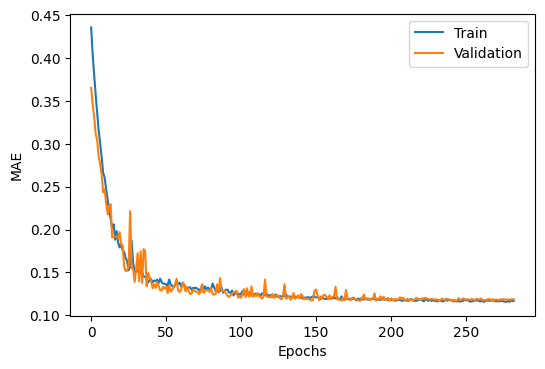

In [327]:
plt.figure(dpi=100, facecolor='white')
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')
# plt.savefig(f'media/LFP/img/loss_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

In [328]:
# slope_mae = model.evaluate([scaled_X_test_time_series, scaled_X_test_dt], scaled_slopes_test)
slope_mae = model.evaluate([scaled_X_test_time_series, scaled_X_test_dt], scaled_slopes_test)


# slope_mae = model.evaluate(scaled_X_test_time_series, scaled_slopes_test)
# test_result = model.evaluate(scaled_X_test_time_series, slopes_test)

6/6 [==============================] - 0s 9ms/step - loss: 0.1117


In [329]:
# dict_results = {'Input_window_size':cycle_window_size,
#                 'Prediction_window_size':cycle_window_size,
#                 'Test MAE':test_result
#                }
# import json
# with open(f'CACHED_DATA/results/LFP/input_window_{cycle_window_size}_output_window_{cycle_window_size}.json', 'w') as f:
#     json.dump(dict_results, f,  indent=4)

In [330]:
Y_hat_test = model.predict([scaled_X_test_time_series, scaled_X_test_dt])
# Y_hat_test = np.log(Y_hat_test)

# Y_hat_test = model.predict(scaled_X_test_time_series)

Y_hat_test = l_scaler.inverse_transform(Y_hat_test)

6/6 [==============================] - 1s 7ms/step


(array([1.800e+01, 1.050e+02, 1.374e+03, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-5.922, -3.654, -1.386,  0.881,  3.149,  5.417,  7.685,  9.952,
        12.22 , 14.488, 16.756]),
 <BarContainer object of 10 artists>)

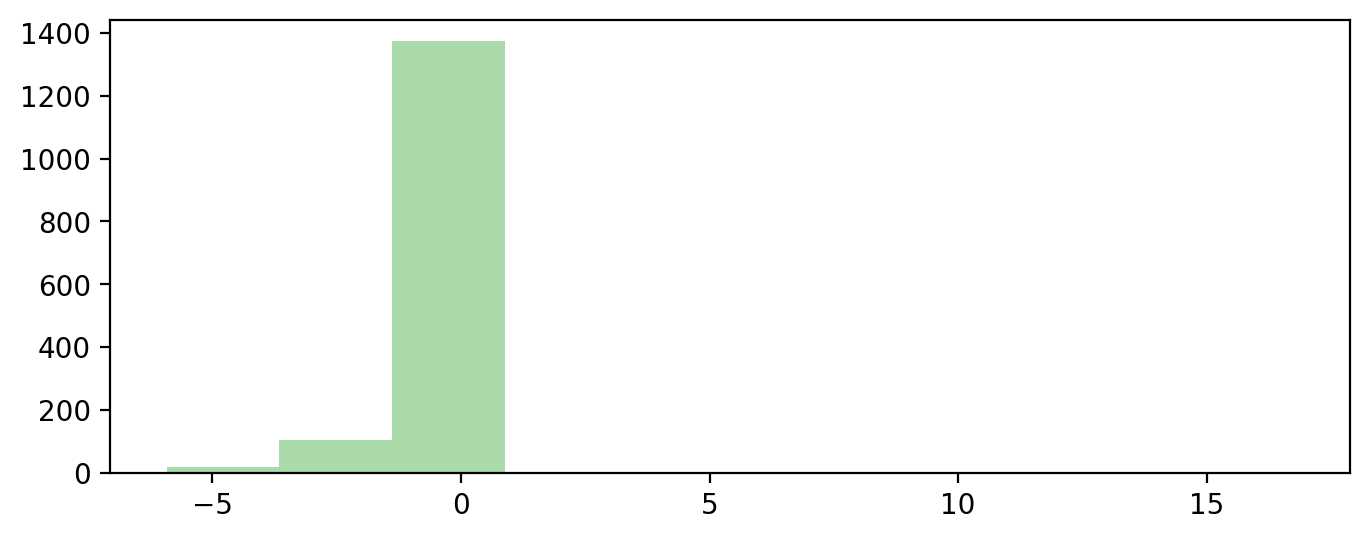

In [331]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
ax.hist(scaled_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')
# ax.hist(scaled_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')
# ax.hist(np.exp(slopes_train[:,0]), alpha=0.4, label='True Train', color='C2')

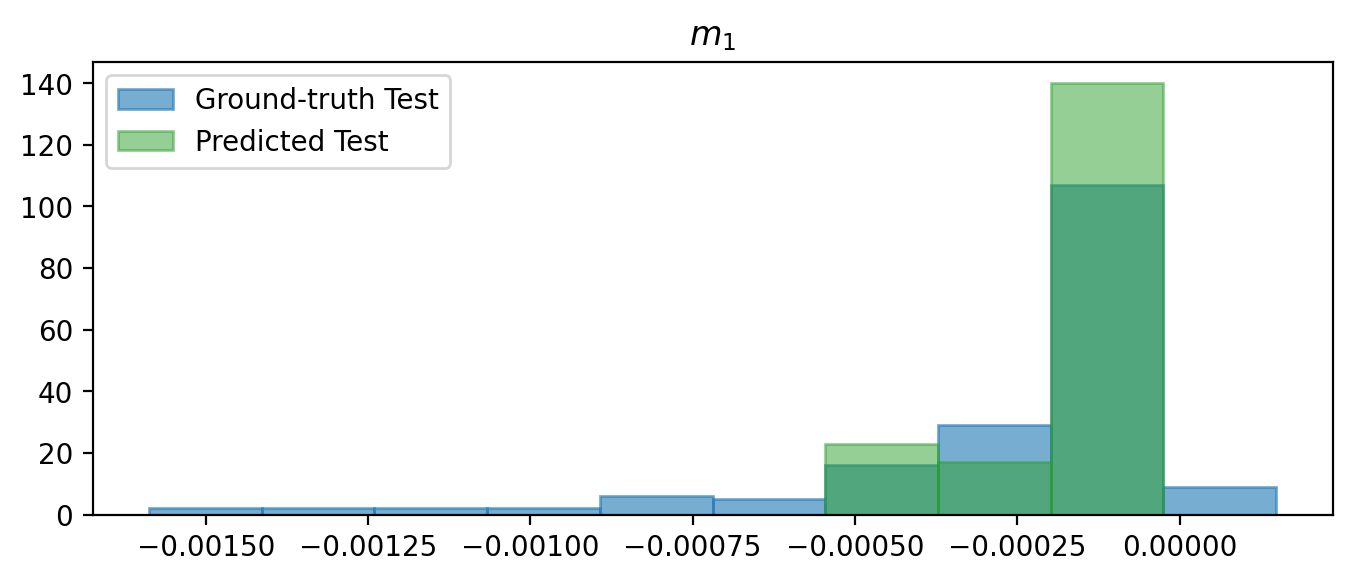

In [332]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,0], bins=10)
ax.hist(slopes_test[:,0], alpha=0.6, label='Ground-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,0],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax[0].set_title('Predicted Test value m1')
# ax.hist(balanced_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_1$')
plt.legend()
# plt.savefig(f'media/LFP/img/m1_hist_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

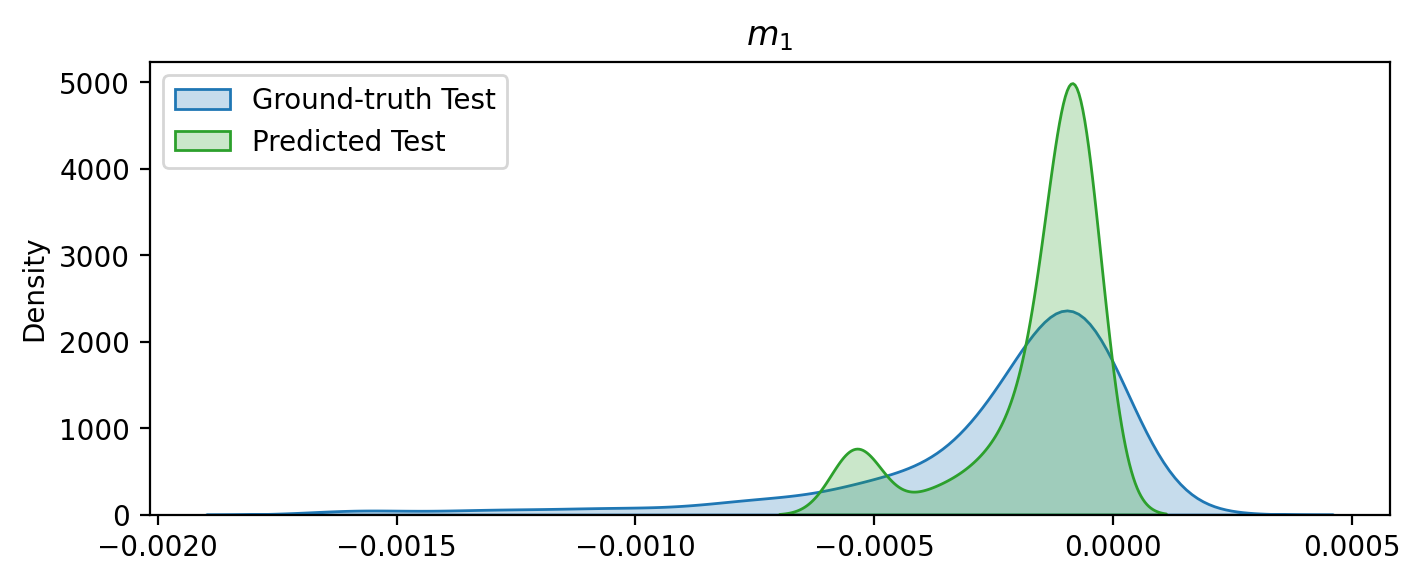

In [333]:
import seaborn as sns
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,0], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,0],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_1$')
plt.legend(loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
# plt.savefig(f'media/LFP/img/m1_kde_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

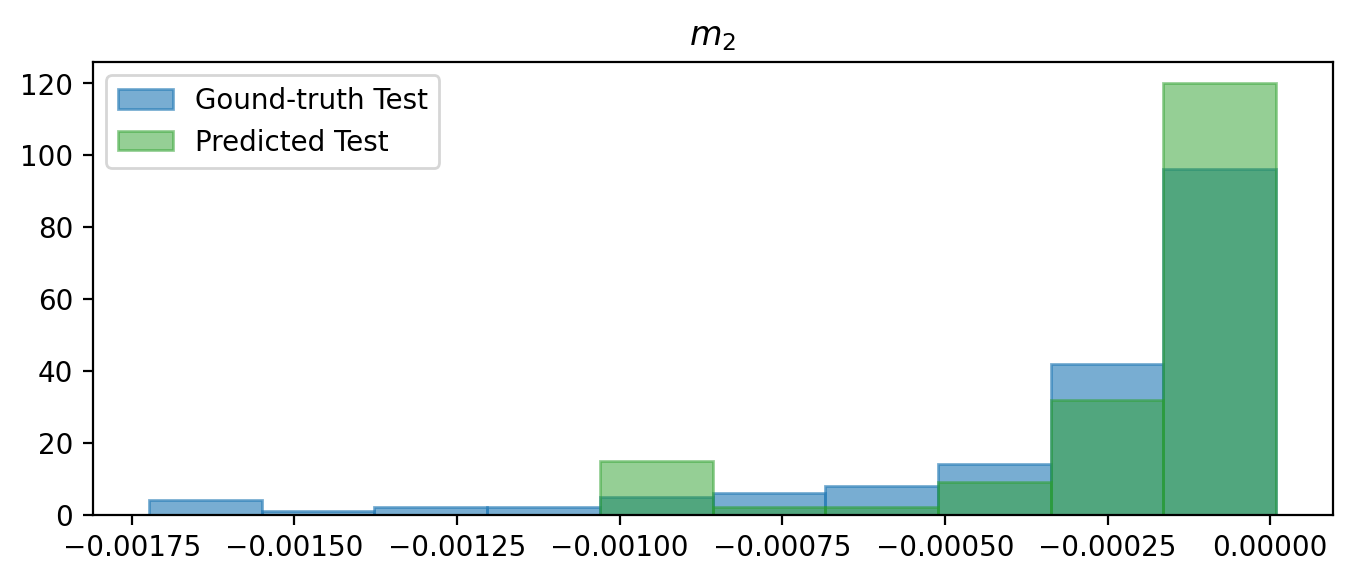

In [334]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,1], bins=10)
ax.hist(slopes_test[:,1], alpha=0.6, label='Gound-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,1],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax.hist(balanced_slopes_train[:,1], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_2$')
plt.legend()
# plt.savefig(f'media/LFP/img/m2_hist_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

(0.0, 5241.129724810535)

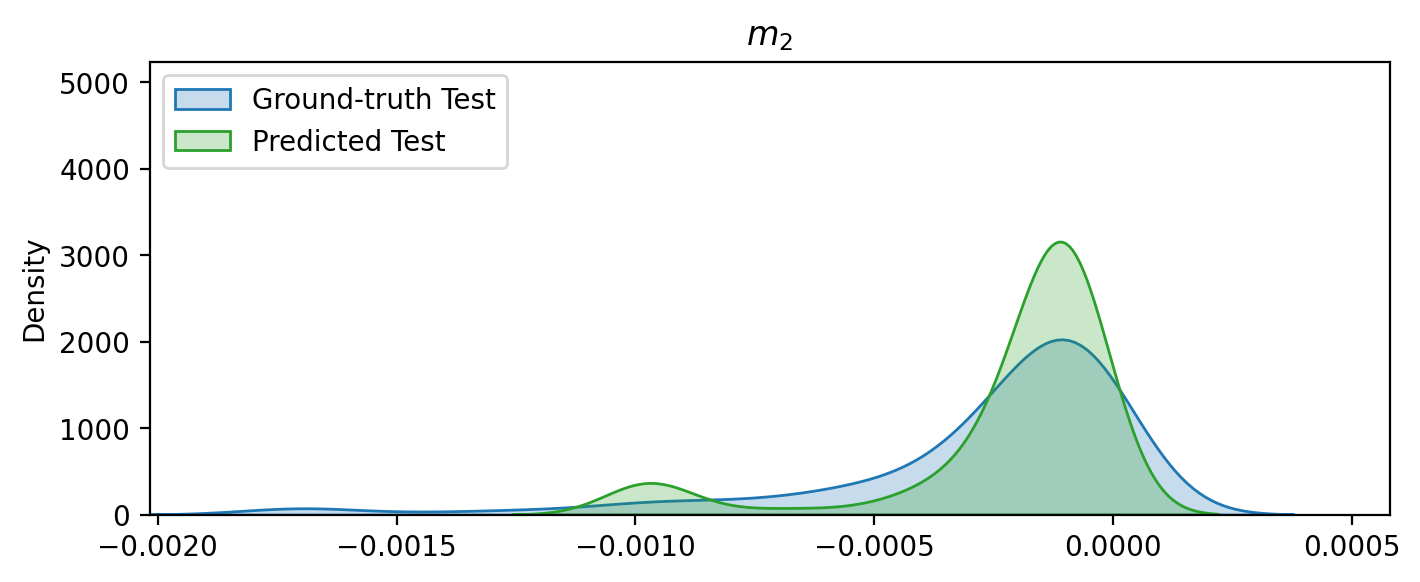

In [335]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,1], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,1],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_2$')
plt.legend(loc='upper left')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# plt.savefig(f'media/LFP/img/m2_kde_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

Text(0, 0.5, 'Predicted Value')

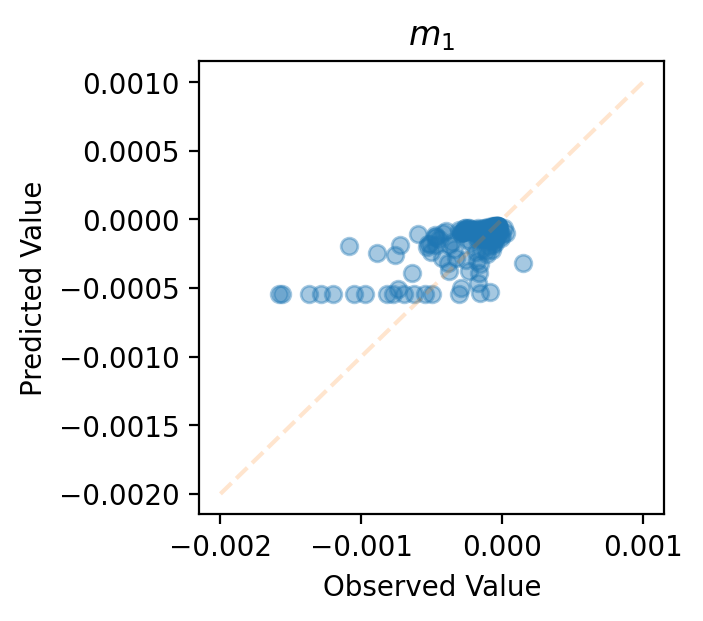

In [336]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,0], Y_hat_test[:,0], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_1$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
# plt.savefig(f'media/LFP/img/m1_parity_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False, bbox_inches="tight")

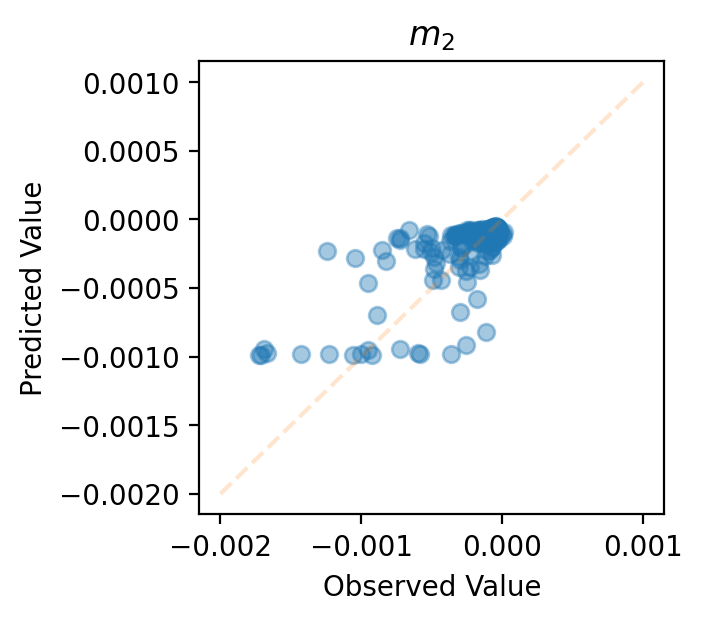

In [337]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,1], Y_hat_test[:,1], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_2$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
ax=plt.gca()
# plt.savefig(f'media/LFP/img/m2_parity_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False, bbox_inches="tight")
# import matplotlib.ticker as mtick
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))

In [338]:
# testing on data
test_cell_number =3
tested_cell = [test_cells[test_cell_number]]
# X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
# Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# Y_test = [x for xs in test_cells for x in xs[1]]
Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
all_test_slopes = [y[0] for y in Y_tested_cell]
all_test_dc = np.array([y[1] for y in Y_tested_cell])
# Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
_, scaled_X_tested_cell_time_series = scale(X_tested_cell_time_series[...,1:], f_scaler)
_, scaled_X_tested_cell_dt = scale(X_tested_cell_dt, dt_scaler)
Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
# Y_hat_tested_cell = model.predict(scaled_X_tested_cell_time_series)

Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)


1/1 [==============================] - 0s 55ms/step


In [339]:
scaled_X_tested_cell_time_series.shape

(13, 50, 100, 3)

In [340]:
Y_hat_tested_cell.shape

(13, 2)

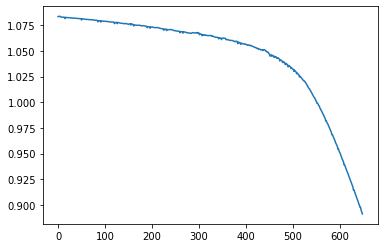

In [341]:
plt.plot(all_test_dc.reshape([-1,2])[1:,1])

predicted slope: -7.929895218694583e-05, True slope: -3.6703999999998516e-05
predicted slope: -9.601353667676449e-05, True slope: -3.6751999999999895e-05
[[51.0, 1.0832438], [75.5, 1.0813009756714198], [100.0, 1.078948644022839]]
predicted slope: -6.692701572319493e-05, True slope: -4.3079999999999784e-05
predicted slope: -8.011526369955391e-05, True slope: -5.376399999999393e-05
[[101.0, 1.0813658], [125.5, 1.0797260881147817], [150.0, 1.0777632641541426]]
predicted slope: -8.433844050159678e-05, True slope: -4.441600000000712e-05
predicted slope: -0.00010238115646643564, True slope: -6.358799999999221e-05
[[151.0, 1.0788846], [175.5, 1.076818308207711], [200.0, 1.0743099698742833]]
predicted slope: -8.175655239028856e-05, True slope: -4.22359999999955e-05
predicted slope: -9.91673514363356e-05, True slope: -7.291999999999633e-05
[[201.0, 1.0760773], [225.5, 1.0740742644664378], [250.0, 1.0716446643562476]]
predicted slope: -9.323782433057204e-05, True slope: -7.006399999999858e-05
pr

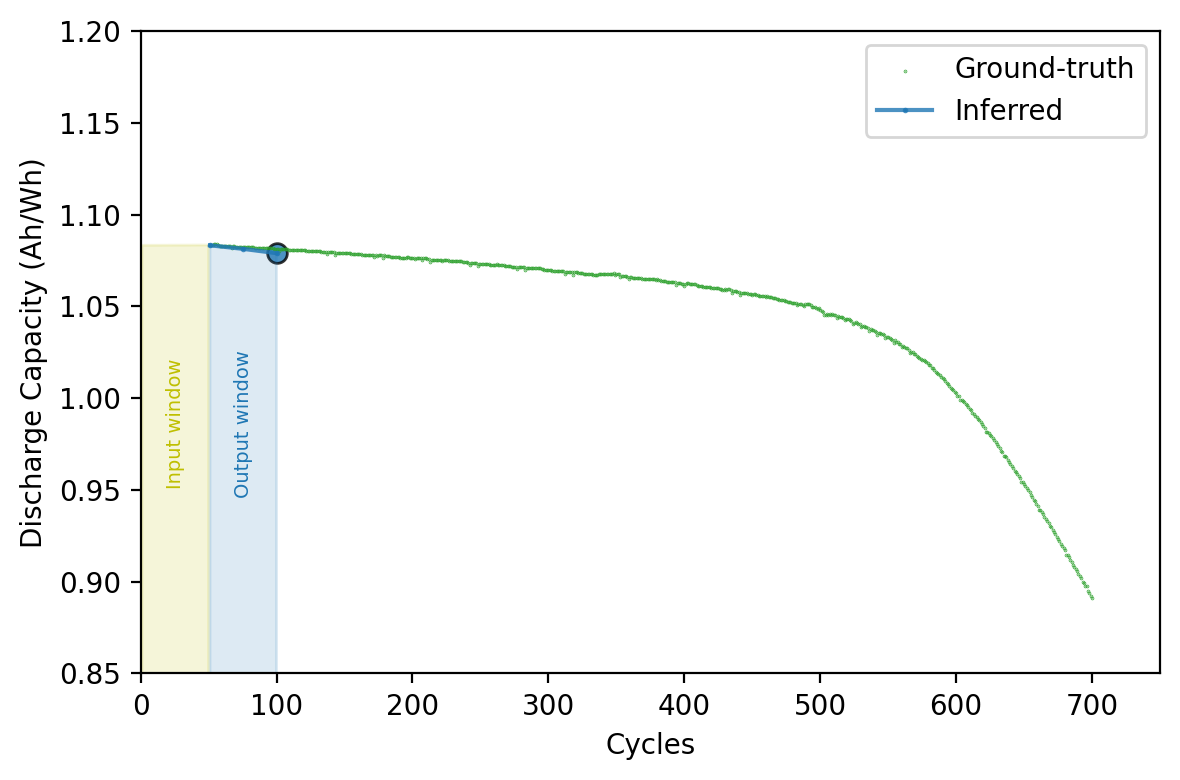

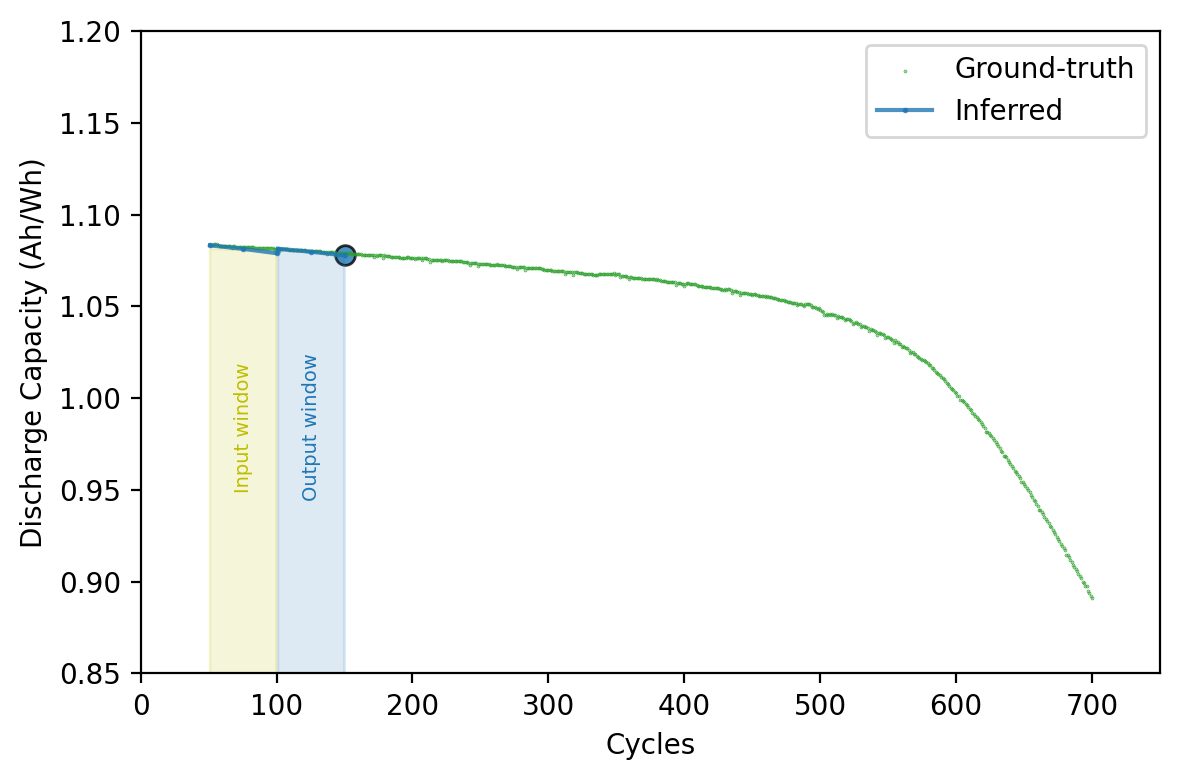

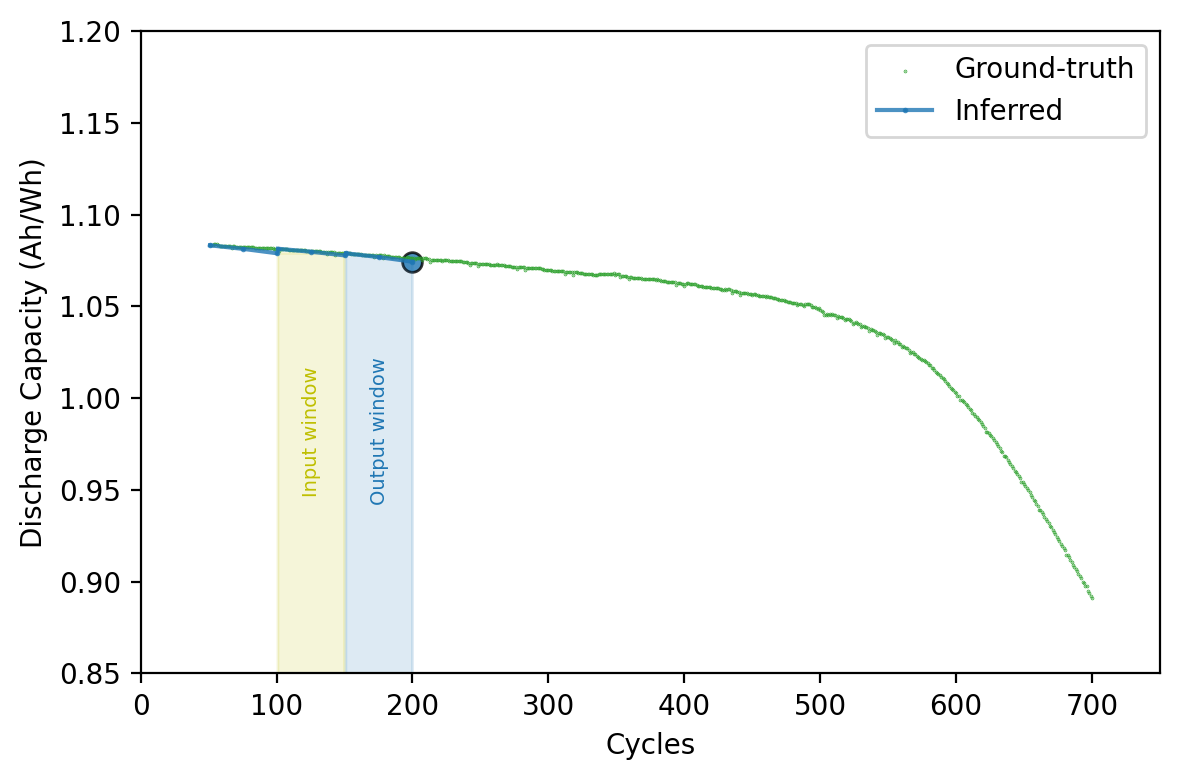

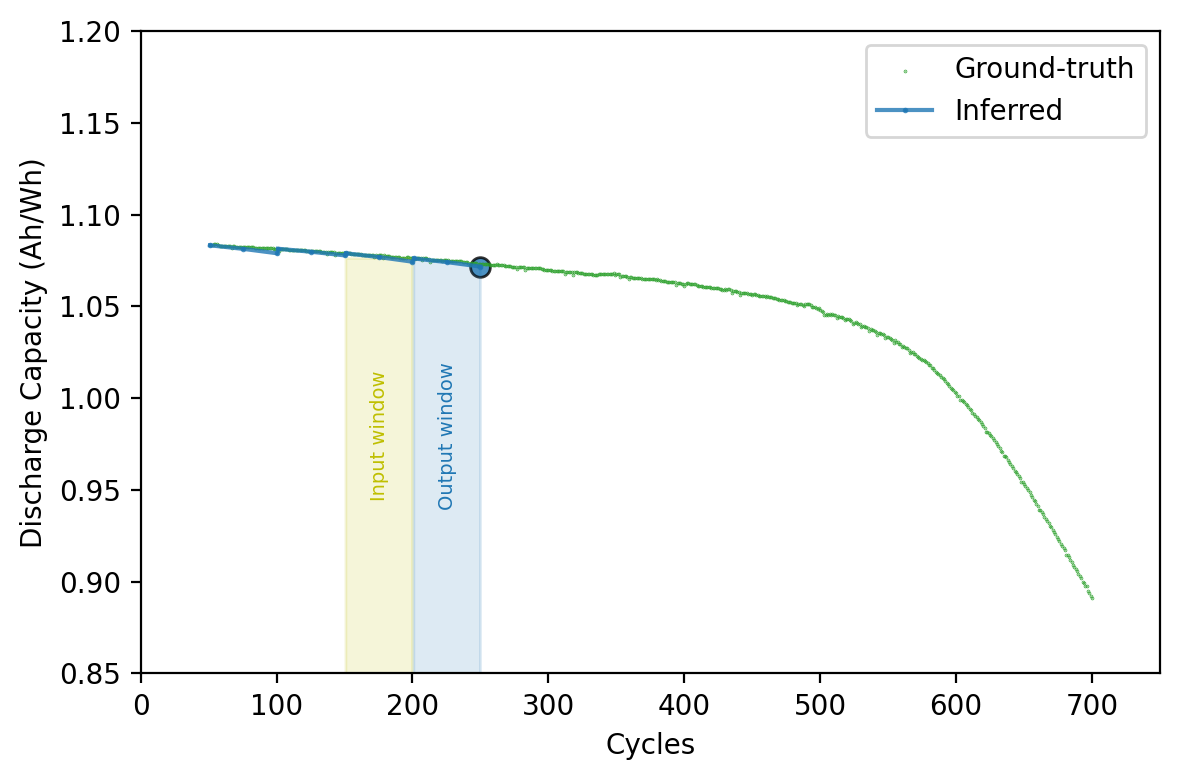

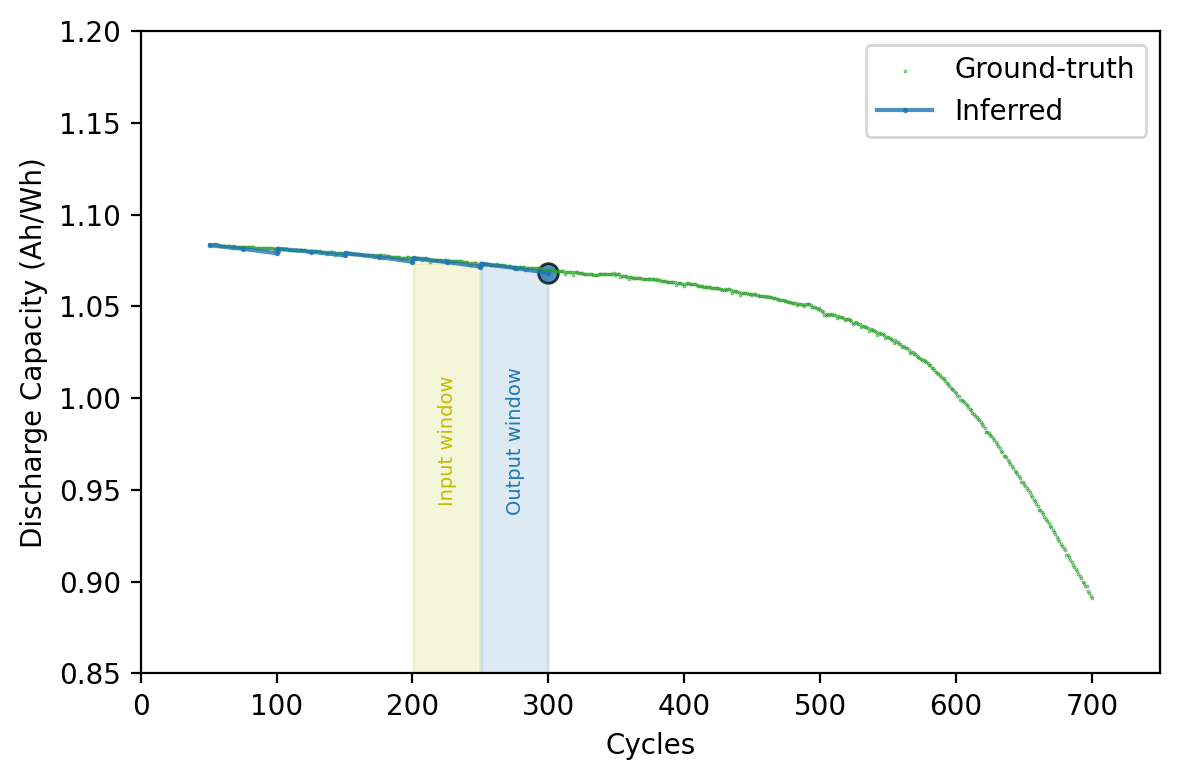

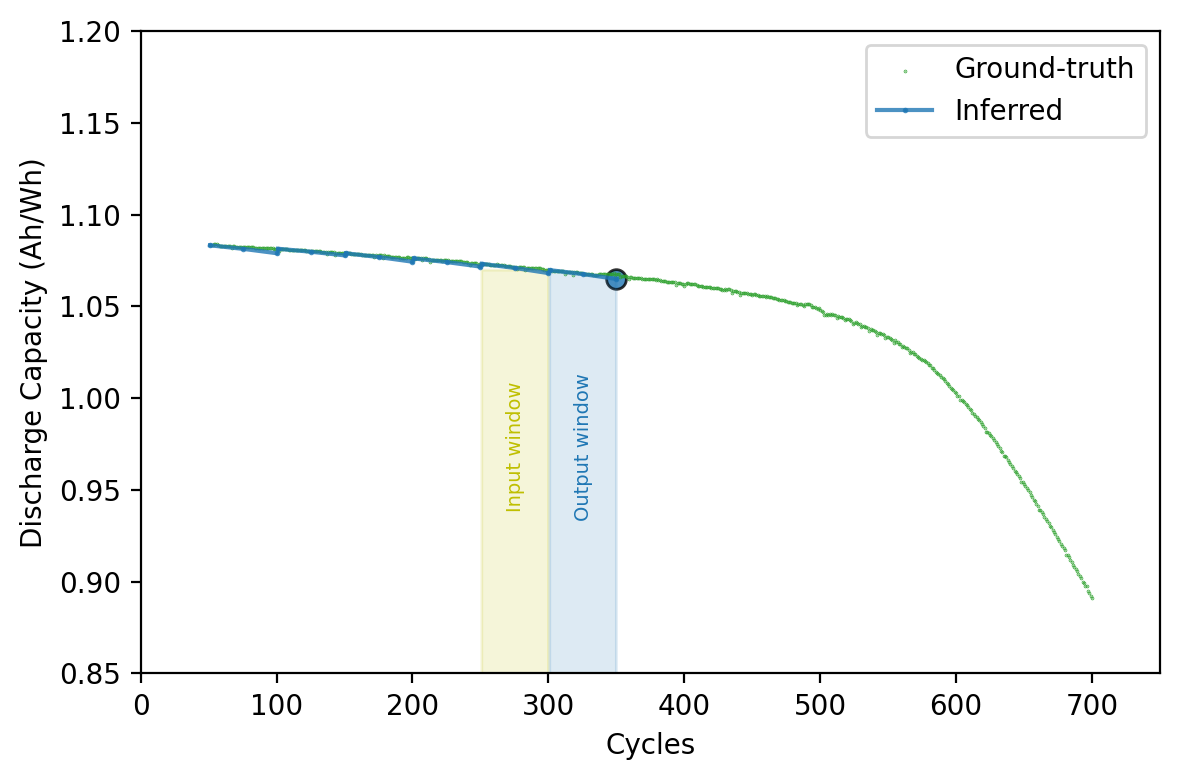

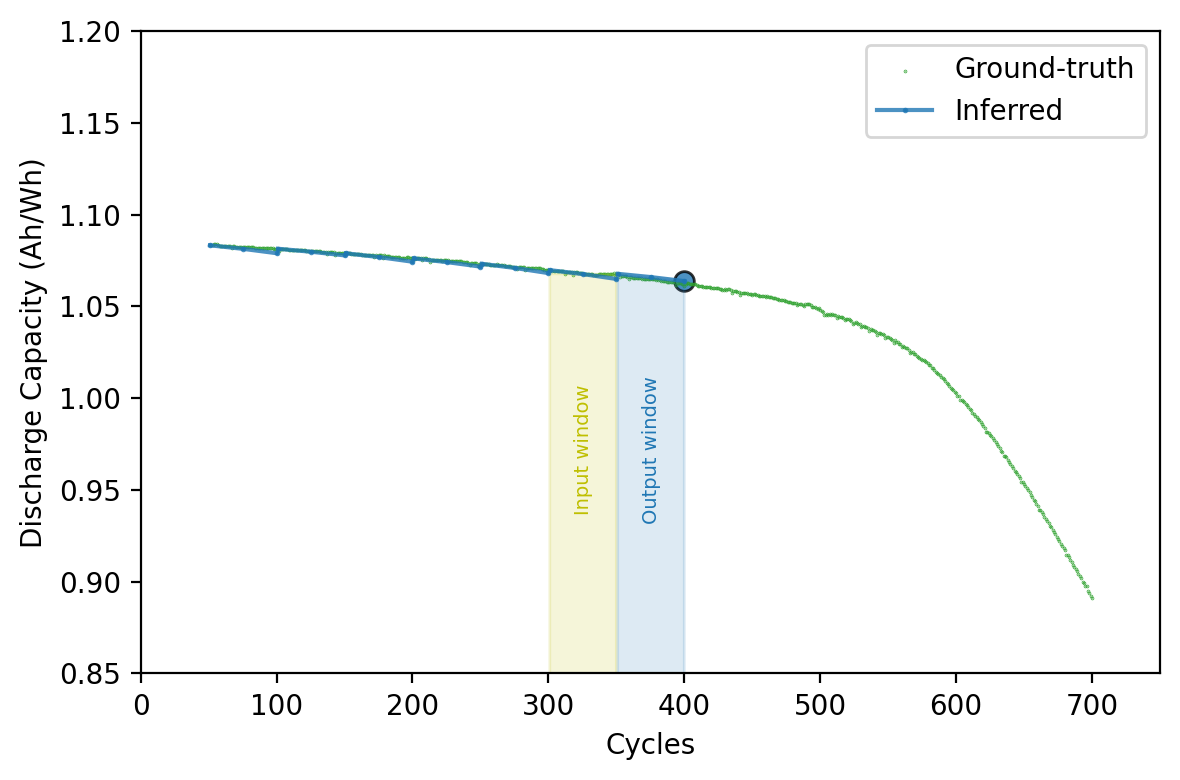

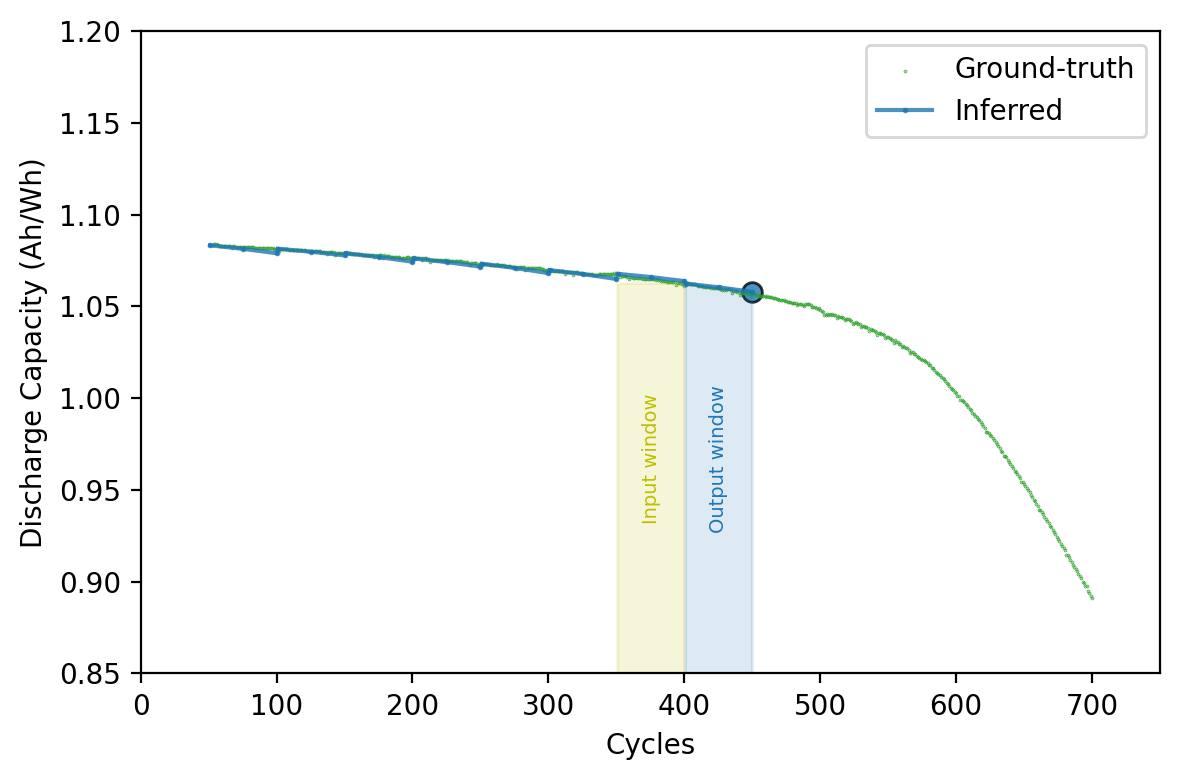

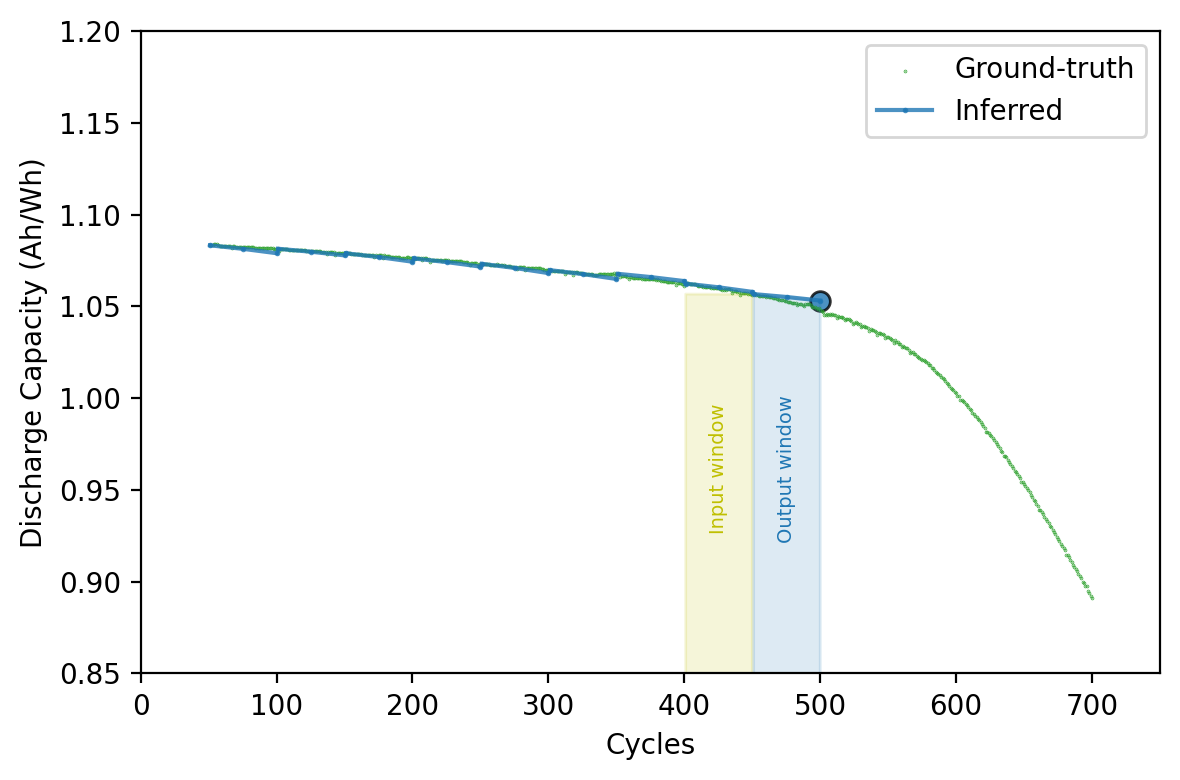

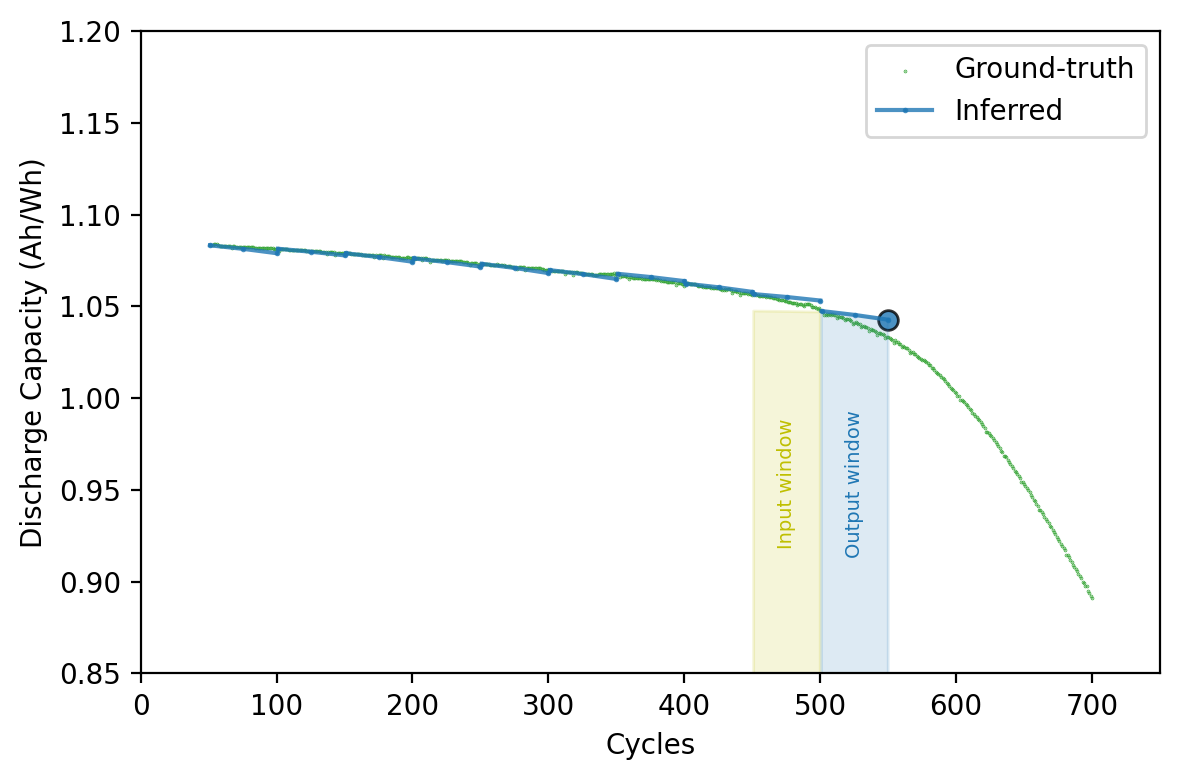

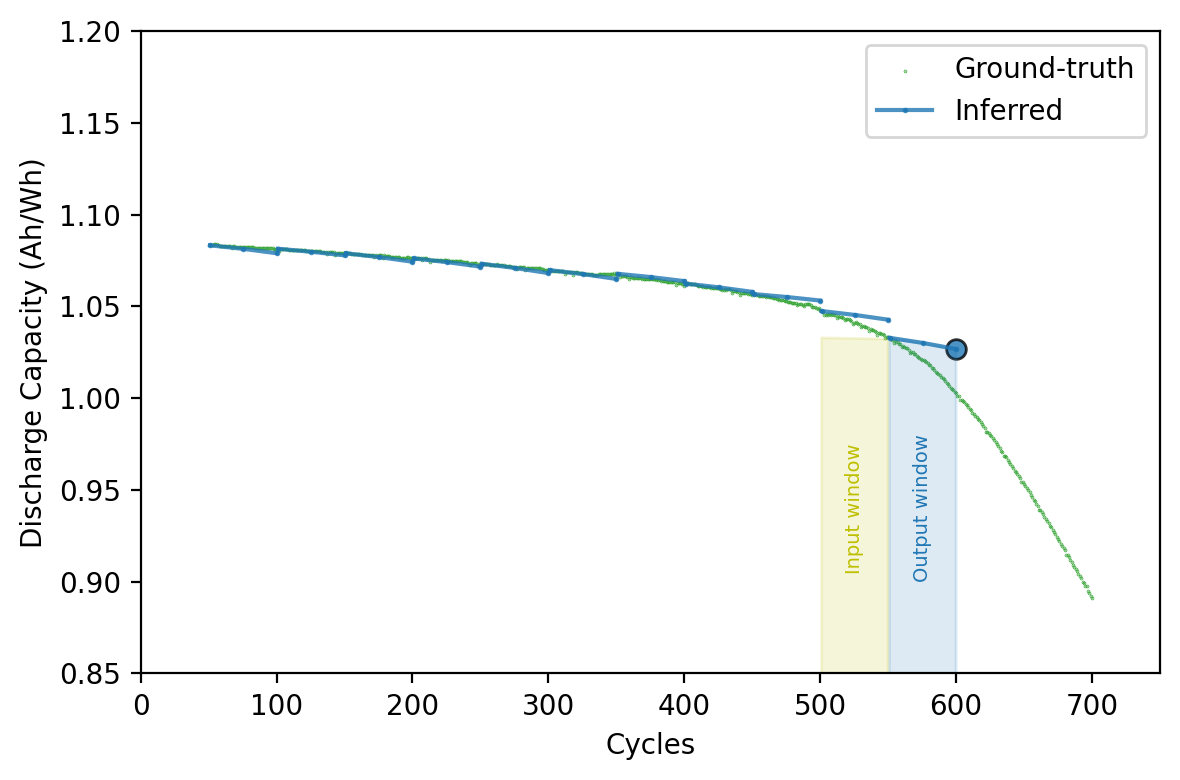

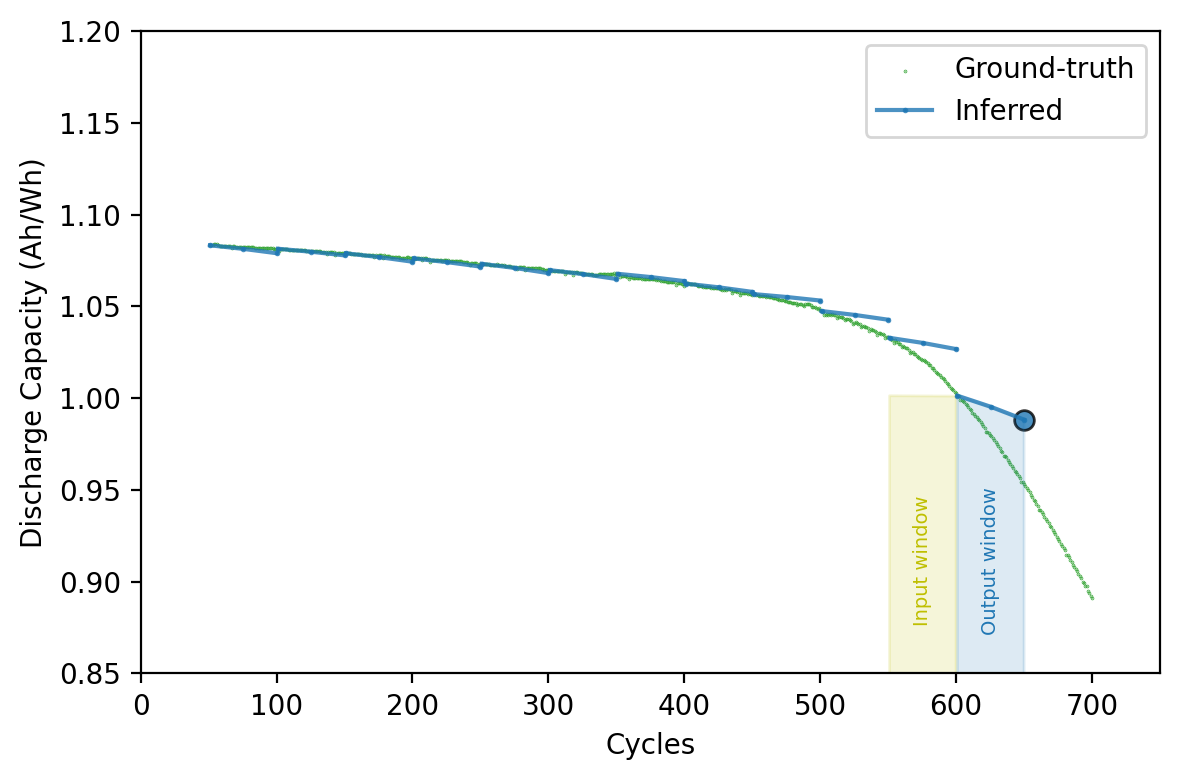

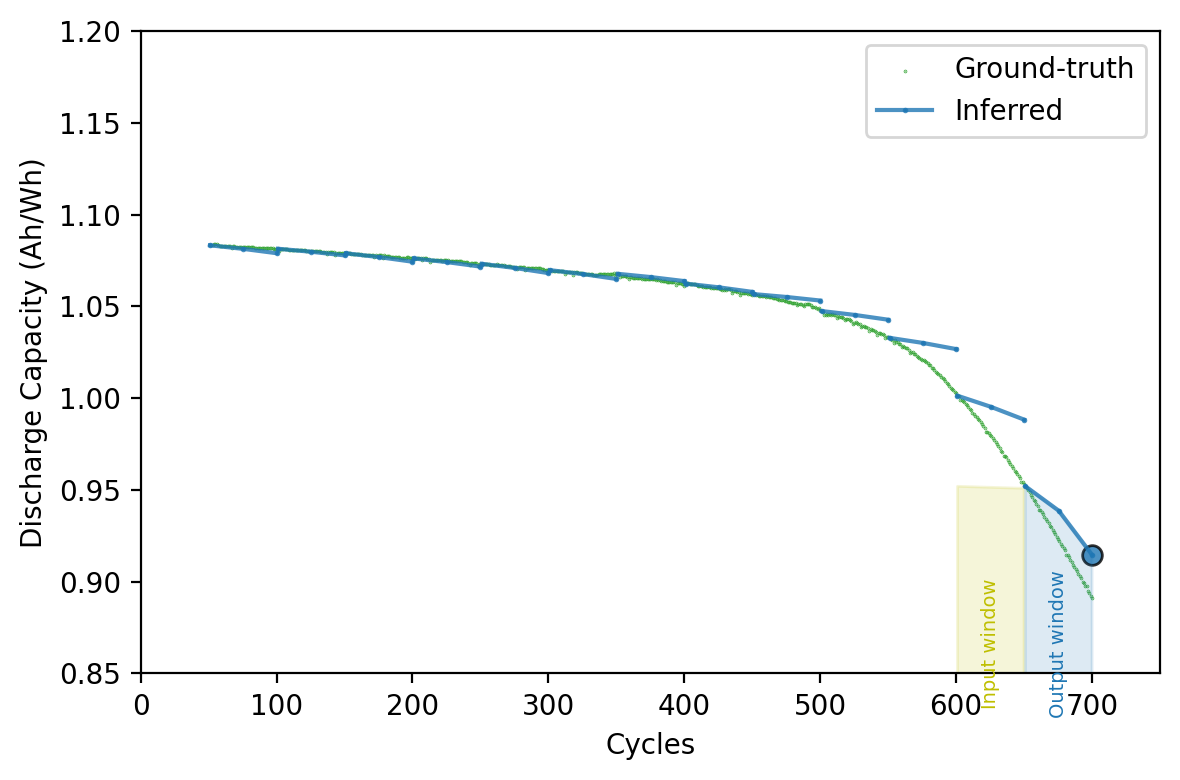

In [342]:
def linear_fit(new_x_point, slope, point_xy):
    return slope*(new_x_point-point_xy[0]) + point_xy[1]

def eval_dc_reconstruction(predicted_dc, ground_truth_dc):
    from scipy.interpolate import interp1d
    f = interp1d(ground_truth_dc[:,0], ground_truth_dc[:,1], kind='cubic')
    interpolated_dc_ground_truth = f(predicted_dc[:,0])
    return np.sqrt(((interpolated_dc_ground_truth - predicted_dc[:,1]) ** 2).mean())


# testing on data
# tested_cell = [test_cells[3]]
# # X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# # Y_train = np.array([x for xs in train_cells for x in xs[1]])
# # Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
# X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# # Y_test = [x for xs in test_cells for x in xs[1]]
# Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
# dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
# X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# # scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# # scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# # std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
# all_test_slopes = [y[0] for y in Y_tested_cell]
# all_test_dc = np.array([y[1] for y in Y_tested_cell])
# # Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
# Y_hat_tested_cell = model.predict(X_tested_cell_time_series[...,1:])

# initial_dc = all_test_dc.reshape([-1, 2])[cycle_indices[0]]
# index_0 = initial_dc[0]
# for i,m in enumerate(all_test_dc.reshape([-1,2])):
#     plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=2, label='Ground-truth' if i == 0 else "")

# window_size = 100
all_predicted_dc_values = []
max_cycle_index = all_test_dc.reshape([-1,2])[-1,0]
for i,m in enumerate(all_test_dc):
    plt.figure(dpi=200, facecolor='white')
#     print(m[0,0], m[5,0], m[9,0])
    plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")
#     if i == 0:
#         initial_dc = m[0]
    initial_dc = m[0].tolist()
#     print(m)
#     print(m)
#     break
    predicted_dc_values = [initial_dc]
#     print(initial_dc)
#     if i%2 == 0:
    new_cycle_index = m[0,0]
#         print(f'hi {i}')
    for j,slope in enumerate(Y_hat_tested_cell[i]):
        new_cycle_index += (output_window_size-1)/2#np.floor(window_size/2)
        new_predicted_dc = linear_fit(new_cycle_index, slope, initial_dc) # slopes_tested_cell[i,j]
#         new_predicted_dc = linear_fit(new_cycle_index, -np.exp(-slope), initial_dc)

        print(f'predicted slope: {slope}, True slope: {np.array(slopes_tested_cell)[i,j]}')
        predicted_dc_values.append([new_cycle_index , new_predicted_dc])
        initial_dc = predicted_dc_values[-1]
#         print(initial_dc)
      # 
    print(predicted_dc_values)
#     break
#     initial_dc = np.array([new_cycle_index, new_predicted_dc]) 
    
#     print(i)
#     print(predicted_dc_values)
#     initial_dc = predicted_dc_values[-1]
    
#     if i==2 or i==1:
#         print(m)
#         break
#     if i ==2:
#         break
    all_predicted_dc_values.append(predicted_dc_values)
#     print(np.array(scatters).T)
    plt.plot(*np.array(all_predicted_dc_values).T, color='C0', label='Inferred', #if i == 0 else "",
             marker='o', markersize=1, alpha=0.8)
    plt.scatter(*np.array(predicted_dc_values[-1]).T, c='C0', #if i == 0 else "",
         marker='o', s=50, edgecolor='k', linewidth=1, facecolor='C0', zorder=-1, alpha=0.8)
    plt.xlabel('Cycles')
    plt.ylabel('Discharge Capacity (Ah/Wh)')
    plt.ylim([0.85,1.2])
    plt.xlim([0 , max_cycle_index+50])
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    plt.legend(np.unique(labl))
    plt.tight_layout()
    show_input_output_windows = True
    if show_input_output_windows:
#         print(*list(zip([all_test_dc[i][0] - output_window_size, all_test_dc[i][0]-1], all_test_dc[i][-1])))
#         print(all_test_dc[i][-1])
#         print(all_test_dc[i][0,0])
        input_window_cycle_index = [all_test_dc[i][0,0] - output_window_size, all_test_dc[i][0,0]-1]
#         print(input_window_cycle_index)
        input_window_dc = [all_test_dc[i][0, -1], all_test_dc[i][1, -1]]
#         print(f'input_window: {all_test_dc[i][0,0]}')
#         print(f'dcvalues {input_window_dc}')
#         print(*list(zip(input_window, input_window_dc)))
#         print(predicted_dc_values)
#         break
        input_fill_between = plt.fill_between(*list([input_window_cycle_index, input_window_dc]), alpha=.15,
                                              edgecolor='y', color='y')
        (x0, y0), (x1, y1) = input_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Input window", ha='center', va='center', fontsize=7, color='y', rotation=90)

        prediction_fill_between = plt.fill_between(*list(zip(*predicted_dc_values)), alpha=.15, edgecolor='C0', color='C0')
        (x0, y0), (x1, y1) = prediction_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Output window", ha='center', va='center', fontsize=7, color='C0', rotation=90)

#     break
    save_gif = False
    if save_gif:
        plt.savefig(f'media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png', dpi=400, transparent=False)
#     if i ==20:
        
#         break
#     plt.close()
#     break
#     if i == 2:
        
#     break

# copy last frame
if save_gif:
    for j in range(10):
        os.system(f"cp media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i+j:04d}.png")
    os.system(f"ffmpeg -framerate 1 -i media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_%04d.png -c:v h264 -crf 14 -c:v libx264 -movflags +faststart -vf format=yuv420p -maxrate 50M -tune animation -bufsize 1MB -t 15 -y media/LFP/mp4/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.mp4")
    os.system(f'ffmpeg -i media/LFP/mp4/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.mp4 -framerate 1 -vf "fps=24, scale=2000:-1:flags=lanczos" -loop 0 -y media/LFP/gif/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.gif')
# ffmpeg -i discharge_curve_50_window_test_3.mp4 -r 40 -vf "fps=20, scale=2000:-1:flags=lanczos" -f image2pipe -vcodec ppm - | convert -delay 10 -loop 0 - test.gif

In [343]:
dc_rmse = eval_dc_reconstruction(np.array(all_predicted_dc_values).reshape(-1,2), all_test_dc.reshape([-1,2]))
dict_results = {'input_window_size':input_window_size,
                'prediction_window_size':output_window_size,
                'test_slope_MAE':slope_mae,
                'test_dc_RMSE': dc_rmse
               }
import json
# with open(f'CACHED_DATA/results/LFP/input_window_{input_window_size}_output_window_{output_window_size}.json', 'w') as f:
#     json.dump(dict_results, f,  indent=4)
dict_results

{'input_window_size': 50,
 'prediction_window_size': 50,
 'test_slope_MAE': 0.11168668419122696,
 'test_dc_RMSE': 0.008968439382723377}

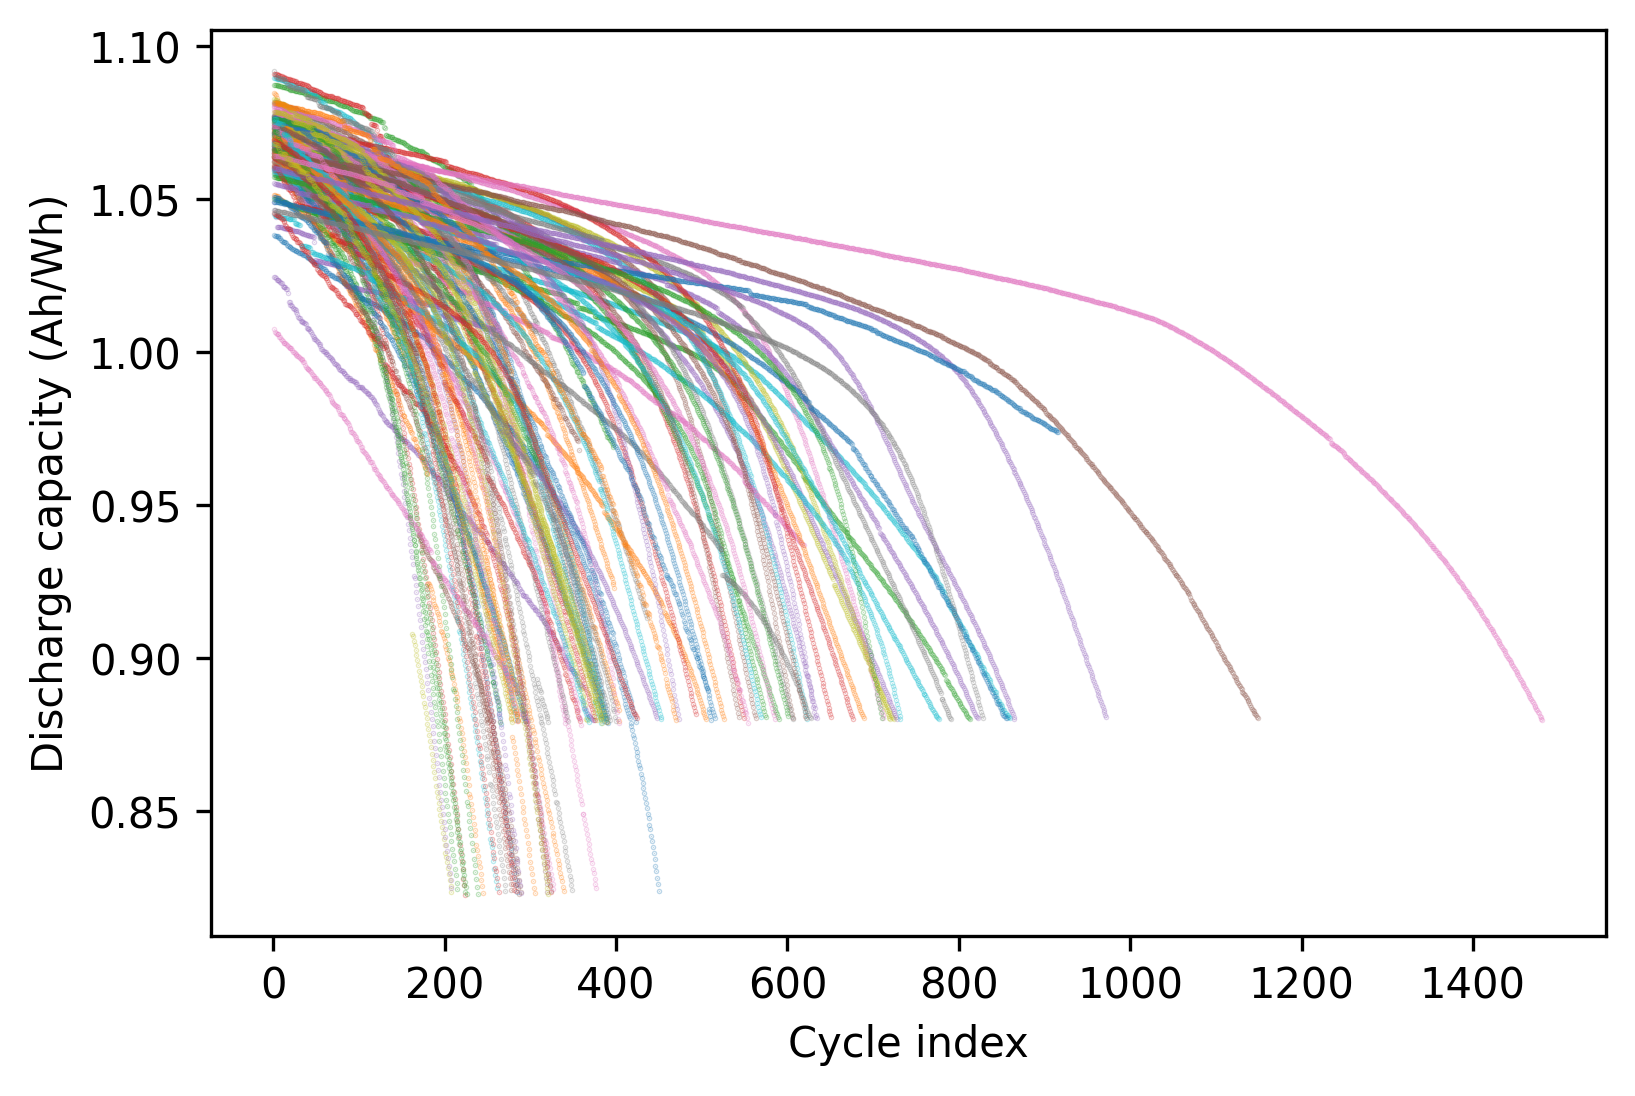

In [33]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycle index')
plt.ylabel('Discharge capacity (Ah/Wh)')
# plt.savefig(f'LFP_dataset.png', dpi=400, transparent=False)